<a href="https://colab.research.google.com/github/Hero0963/ML_2021/blob/main/ML_2021_hw03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.7.14


In [ ]:
# Download the dataset
# You may choose where to download the data.

# Google Drive
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Dropbox
# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# MEGA
# !sudo apt install megatools
# !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# Unzip the dataset.
# This may take some time.
!unzip -q food-11.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy
To: /content/food-11.zip
100% 963M/963M [00:05<00:00, 181MB/s]


In [ ]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm import tqdm

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.

do_image_augmentation=True

train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

train_tfm1 = transforms.Compose([
     # Resize the image into a fixed shape (height = width = 128)
     transforms.Resize((128, 128)),
    
     transforms.ToTensor(),
])

train_tfm2 = transforms.Compose([
     transforms.Resize((128, 128)),
     transforms.RandomPerspective(p=1.0),
     transforms.ToTensor(),
])

train_tfm3 = transforms.Compose([
     transforms.Resize((128, 128)),
     transforms.RandomRotation((0, 180)),
     transforms.ToTensor(),
])

train_tfm4 = transforms.Compose([
     transforms.Resize((128, 128)),
     transforms.RandomCrop((128, 128)),
     transforms.ToTensor(),
])


# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 256

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)

if do_image_augmentation:
  train_set1 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm1)
  train_set2 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm2) 
  train_set3 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm3)
  train_set4 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm4)
  train_set = ConcatDataset([train_set,train_set1, train_set2, train_set3, train_set4])
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )

   
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
def get_pseudo_labels(dataset, model, threshold=0.85):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for batch in tqdm(data_loader):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # ---------- TODO ----------
        # Filter the data and construct a new dataset.

    # # Turn off the eval mode.
    model.train()
    return dataset

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# Resnet load
model = torchvision.models.resnet18(pretrained=False).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11).to(device)
model.device = device
for param in model.parameters():
    param.requires_grad = True


# model = Classifier().to(device)
# model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 800

best_acc = 0.0
train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []
model_path = "model.ckpt"

# Whether to do semi-supervised learning.
do_semi = True

for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi and best_acc > 0.85 :
        # Obtain pseudo-labels for unlabeled data using trained model.
        pseudo_set = get_pseudo_labels(unlabeled_set, model)

        # Construct a new dataset and a data loader for training.
        # This is used in semi-supervised learning only.
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ],    loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ],    loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)

    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_acc_record.append(train_acc)
    valid_acc_record.append(valid_acc)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 61/61 [01:22<00:00,  1.35s/it]


[ Train | 001/800 ],    loss = 1.73417, acc = 0.40088


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 001/800 ],    loss = 2.30606, acc = 0.29054


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 002/800 ],    loss = 0.98825, acc = 0.67993


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 002/800 ],    loss = 2.11731, acc = 0.36571


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 003/800 ],    loss = 0.72529, acc = 0.76696


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


[ Valid | 003/800 ],    loss = 2.47321, acc = 0.39735


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 004/800 ],    loss = 0.63333, acc = 0.79142


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


[ Valid | 004/800 ],    loss = 2.78553, acc = 0.37648


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 005/800 ],    loss = 0.58397, acc = 0.80738


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


[ Valid | 005/800 ],    loss = 2.63111, acc = 0.38074


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 006/800 ],    loss = 0.54739, acc = 0.81952


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 006/800 ],    loss = 2.14593, acc = 0.43627


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 007/800 ],    loss = 0.50954, acc = 0.83094


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 007/800 ],    loss = 2.68039, acc = 0.41082


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 008/800 ],    loss = 0.47351, acc = 0.84084


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 008/800 ],    loss = 2.82053, acc = 0.39126


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 009/800 ],    loss = 0.43755, acc = 0.85434


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 009/800 ],    loss = 2.25993, acc = 0.43595


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 010/800 ],    loss = 0.40074, acc = 0.86559


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


[ Valid | 010/800 ],    loss = 2.13087, acc = 0.47653


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 011/800 ],    loss = 0.39127, acc = 0.86990


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 011/800 ],    loss = 2.08655, acc = 0.46805


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 012/800 ],    loss = 0.37668, acc = 0.87500


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 012/800 ],    loss = 2.30580, acc = 0.45869


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 013/800 ],    loss = 0.36009, acc = 0.88107


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 013/800 ],    loss = 2.40960, acc = 0.46565


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 014/800 ],    loss = 0.32435, acc = 0.89153


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 014/800 ],    loss = 2.27852, acc = 0.47501


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 015/800 ],    loss = 0.30495, acc = 0.89598


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 015/800 ],    loss = 2.73792, acc = 0.42409


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 016/800 ],    loss = 0.28692, acc = 0.90182


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 016/800 ],    loss = 2.55450, acc = 0.43866


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 017/800 ],    loss = 0.27951, acc = 0.90738


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 017/800 ],    loss = 2.96383, acc = 0.42659


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 018/800 ],    loss = 0.26127, acc = 0.91270


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 018/800 ],    loss = 2.64365, acc = 0.46435


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 019/800 ],    loss = 0.24241, acc = 0.91956


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 019/800 ],    loss = 2.54349, acc = 0.48152


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 020/800 ],    loss = 0.23748, acc = 0.92099


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 020/800 ],    loss = 2.61414, acc = 0.47596


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 021/800 ],    loss = 0.20967, acc = 0.93001


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 021/800 ],    loss = 2.36439, acc = 0.48001


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 022/800 ],    loss = 0.20620, acc = 0.93265


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


[ Valid | 022/800 ],    loss = 2.36848, acc = 0.48603


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 023/800 ],    loss = 0.18010, acc = 0.94105


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 023/800 ],    loss = 2.49531, acc = 0.46354


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 024/800 ],    loss = 0.18958, acc = 0.93434


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 024/800 ],    loss = 2.65376, acc = 0.45583


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 025/800 ],    loss = 0.16569, acc = 0.94440


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 025/800 ],    loss = 2.46003, acc = 0.48543


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 026/800 ],    loss = 0.16795, acc = 0.94349


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 026/800 ],    loss = 2.61384, acc = 0.47002


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 027/800 ],    loss = 0.15295, acc = 0.94740


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 027/800 ],    loss = 2.55180, acc = 0.49124


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 028/800 ],    loss = 0.14512, acc = 0.95033


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 028/800 ],    loss = 2.48258, acc = 0.48508


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 029/800 ],    loss = 0.13187, acc = 0.95768


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 029/800 ],    loss = 2.36161, acc = 0.47276


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 030/800 ],    loss = 0.14247, acc = 0.95288


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 030/800 ],    loss = 2.63326, acc = 0.49289


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 031/800 ],    loss = 0.13605, acc = 0.95384


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 031/800 ],    loss = 2.65973, acc = 0.48328


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 032/800 ],    loss = 0.12163, acc = 0.95978


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 032/800 ],    loss = 2.70658, acc = 0.50060


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 033/800 ],    loss = 0.11277, acc = 0.96218


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 033/800 ],    loss = 3.23013, acc = 0.47311


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 034/800 ],    loss = 0.12740, acc = 0.95914


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 034/800 ],    loss = 2.70989, acc = 0.48828


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 035/800 ],    loss = 0.09489, acc = 0.96924


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 035/800 ],    loss = 2.32801, acc = 0.51661


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 036/800 ],    loss = 0.09860, acc = 0.96570


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 036/800 ],    loss = 2.60604, acc = 0.49835


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 037/800 ],    loss = 0.10889, acc = 0.96270


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 037/800 ],    loss = 2.56260, acc = 0.52263


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 038/800 ],    loss = 0.10329, acc = 0.96620


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 038/800 ],    loss = 2.55335, acc = 0.52263


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 039/800 ],    loss = 0.09158, acc = 0.96983


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 039/800 ],    loss = 2.65570, acc = 0.49919


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 040/800 ],    loss = 0.08586, acc = 0.97088


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 040/800 ],    loss = 2.67942, acc = 0.50320


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 041/800 ],    loss = 0.07186, acc = 0.97546


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 041/800 ],    loss = 2.59445, acc = 0.49951


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 042/800 ],    loss = 0.09501, acc = 0.96766


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 042/800 ],    loss = 2.43867, acc = 0.51745


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 043/800 ],    loss = 0.08006, acc = 0.97357


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


[ Valid | 043/800 ],    loss = 2.54056, acc = 0.51292


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 044/800 ],    loss = 0.07789, acc = 0.97468


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 044/800 ],    loss = 2.62045, acc = 0.49148


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 045/800 ],    loss = 0.07413, acc = 0.97508


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 045/800 ],    loss = 3.03999, acc = 0.45344


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 046/800 ],    loss = 0.07868, acc = 0.97456


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 046/800 ],    loss = 2.60949, acc = 0.49585


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 047/800 ],    loss = 0.08032, acc = 0.97189


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 047/800 ],    loss = 2.40094, acc = 0.51988


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 048/800 ],    loss = 0.08636, acc = 0.97171


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 048/800 ],    loss = 2.68307, acc = 0.47311


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 049/800 ],    loss = 0.08486, acc = 0.97295


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 049/800 ],    loss = 3.67826, acc = 0.41508


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 050/800 ],    loss = 0.07888, acc = 0.97293


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 050/800 ],    loss = 2.44860, acc = 0.50239


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 051/800 ],    loss = 0.06424, acc = 0.97987


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 051/800 ],    loss = 2.82612, acc = 0.47392


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 052/800 ],    loss = 0.06297, acc = 0.97878


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


[ Valid | 052/800 ],    loss = 2.75520, acc = 0.50401


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 053/800 ],    loss = 0.06844, acc = 0.97795


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 053/800 ],    loss = 2.55336, acc = 0.53069


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 054/800 ],    loss = 0.05095, acc = 0.98309


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 054/800 ],    loss = 3.04385, acc = 0.50116


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 055/800 ],    loss = 0.04203, acc = 0.98669


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 055/800 ],    loss = 2.78603, acc = 0.53730


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 056/800 ],    loss = 0.06753, acc = 0.97765


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 056/800 ],    loss = 2.79668, acc = 0.52653


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 057/800 ],    loss = 0.05032, acc = 0.98204


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 057/800 ],    loss = 2.82268, acc = 0.49965


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 058/800 ],    loss = 0.04817, acc = 0.98321


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 058/800 ],    loss = 2.74073, acc = 0.49560


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 059/800 ],    loss = 0.07110, acc = 0.97609


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 059/800 ],    loss = 3.23834, acc = 0.48117


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 060/800 ],    loss = 0.06142, acc = 0.97993


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


[ Valid | 060/800 ],    loss = 2.55070, acc = 0.54096


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 061/800 ],    loss = 0.06651, acc = 0.97823


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 061/800 ],    loss = 3.62098, acc = 0.45488


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 062/800 ],    loss = 0.06381, acc = 0.98021


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 062/800 ],    loss = 2.88401, acc = 0.49930


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 063/800 ],    loss = 0.04772, acc = 0.98496


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 063/800 ],    loss = 2.74093, acc = 0.50521


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 064/800 ],    loss = 0.06582, acc = 0.97852


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 064/800 ],    loss = 2.98885, acc = 0.51042


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 065/800 ],    loss = 0.04542, acc = 0.98514


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 065/800 ],    loss = 2.75032, acc = 0.52073


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 066/800 ],    loss = 0.03201, acc = 0.99005


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 066/800 ],    loss = 2.75477, acc = 0.47818


100%|██████████| 61/61 [01:22<00:00,  1.36s/it]


[ Train | 067/800 ],    loss = 0.04382, acc = 0.98503


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 067/800 ],    loss = 2.72951, acc = 0.52203


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 068/800 ],    loss = 0.06559, acc = 0.97752


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 068/800 ],    loss = 2.77904, acc = 0.52583


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 069/800 ],    loss = 0.05183, acc = 0.98162


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 069/800 ],    loss = 2.71127, acc = 0.54906


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 070/800 ],    loss = 0.04999, acc = 0.98364


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 070/800 ],    loss = 2.66738, acc = 0.53495


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 071/800 ],    loss = 0.05554, acc = 0.97956


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 071/800 ],    loss = 2.69743, acc = 0.53114


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 072/800 ],    loss = 0.06823, acc = 0.97833


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 072/800 ],    loss = 3.24904, acc = 0.48047


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 073/800 ],    loss = 0.04765, acc = 0.98450


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 073/800 ],    loss = 2.88550, acc = 0.51647


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 074/800 ],    loss = 0.02819, acc = 0.99135


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 074/800 ],    loss = 2.50739, acc = 0.56063


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 075/800 ],    loss = 0.03150, acc = 0.98896


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 075/800 ],    loss = 2.52685, acc = 0.53575


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 076/800 ],    loss = 0.03706, acc = 0.98787


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 076/800 ],    loss = 2.81831, acc = 0.53399


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 077/800 ],    loss = 0.05487, acc = 0.98198


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 077/800 ],    loss = 3.18153, acc = 0.48578


100%|██████████| 61/61 [01:24<00:00,  1.38s/it]


[ Train | 078/800 ],    loss = 0.04618, acc = 0.98426


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 078/800 ],    loss = 2.61116, acc = 0.53009


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 079/800 ],    loss = 0.05619, acc = 0.98031


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


[ Valid | 079/800 ],    loss = 2.80356, acc = 0.53009


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 080/800 ],    loss = 0.04844, acc = 0.98303


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 080/800 ],    loss = 2.68030, acc = 0.53575


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 081/800 ],    loss = 0.03816, acc = 0.98714


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 081/800 ],    loss = 3.04967, acc = 0.50531


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 082/800 ],    loss = 0.04957, acc = 0.98300


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 082/800 ],    loss = 2.87562, acc = 0.51587


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 083/800 ],    loss = 0.03667, acc = 0.98768


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 083/800 ],    loss = 3.36685, acc = 0.47677


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 084/800 ],    loss = 0.03955, acc = 0.98777


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 084/800 ],    loss = 3.04220, acc = 0.53836


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 085/800 ],    loss = 0.04121, acc = 0.98610


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 085/800 ],    loss = 3.03814, acc = 0.51492


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 086/800 ],    loss = 0.04003, acc = 0.98713


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 086/800 ],    loss = 2.76303, acc = 0.52333


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 087/800 ],    loss = 0.03680, acc = 0.98873


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 087/800 ],    loss = 2.83523, acc = 0.52794


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 088/800 ],    loss = 0.04462, acc = 0.98595


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 088/800 ],    loss = 3.48291, acc = 0.47832


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 089/800 ],    loss = 0.04510, acc = 0.98572


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 089/800 ],    loss = 3.45091, acc = 0.46340


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 090/800 ],    loss = 0.03365, acc = 0.98870


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 090/800 ],    loss = 2.90989, acc = 0.52073


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 091/800 ],    loss = 0.03659, acc = 0.98713


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 091/800 ],    loss = 3.28896, acc = 0.50250


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 092/800 ],    loss = 0.03196, acc = 0.98995


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 092/800 ],    loss = 2.98836, acc = 0.49764


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 093/800 ],    loss = 0.02809, acc = 0.99162


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 093/800 ],    loss = 2.99572, acc = 0.53009


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 094/800 ],    loss = 0.05610, acc = 0.98175


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 094/800 ],    loss = 2.95457, acc = 0.48022


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 095/800 ],    loss = 0.04220, acc = 0.98537


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 095/800 ],    loss = 2.96136, acc = 0.51482


100%|██████████| 61/61 [01:19<00:00,  1.30s/it]


[ Train | 096/800 ],    loss = 0.05024, acc = 0.98352


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 096/800 ],    loss = 3.21379, acc = 0.48663


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 097/800 ],    loss = 0.04406, acc = 0.98540


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 097/800 ],    loss = 2.45466, acc = 0.55532


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 098/800 ],    loss = 0.03551, acc = 0.99028


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 098/800 ],    loss = 2.87595, acc = 0.54550


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 099/800 ],    loss = 0.05485, acc = 0.98174


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 099/800 ],    loss = 3.34042, acc = 0.46101


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 100/800 ],    loss = 0.07040, acc = 0.97856


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 100/800 ],    loss = 3.30153, acc = 0.49089


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 101/800 ],    loss = 0.04613, acc = 0.98521


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 101/800 ],    loss = 2.57646, acc = 0.53019


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 102/800 ],    loss = 0.02595, acc = 0.99133


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 102/800 ],    loss = 2.61636, acc = 0.55092


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 103/800 ],    loss = 0.02273, acc = 0.99214


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 103/800 ],    loss = 2.72898, acc = 0.50922


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 104/800 ],    loss = 0.02789, acc = 0.99097


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 104/800 ],    loss = 2.66360, acc = 0.55138


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 105/800 ],    loss = 0.01589, acc = 0.99475


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 105/800 ],    loss = 2.85809, acc = 0.52143


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 106/800 ],    loss = 0.01959, acc = 0.99315


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 106/800 ],    loss = 3.24013, acc = 0.48698


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 107/800 ],    loss = 0.02963, acc = 0.99041


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 107/800 ],    loss = 2.74324, acc = 0.53354


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 108/800 ],    loss = 0.04120, acc = 0.98655


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 108/800 ],    loss = 2.67695, acc = 0.53364


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 109/800 ],    loss = 0.01788, acc = 0.99449


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 109/800 ],    loss = 2.77866, acc = 0.55011


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 110/800 ],    loss = 0.02031, acc = 0.99434


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 110/800 ],    loss = 2.75249, acc = 0.52865


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 111/800 ],    loss = 0.03840, acc = 0.98649


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 111/800 ],    loss = 3.01222, acc = 0.50531


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 112/800 ],    loss = 0.03587, acc = 0.98809


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 112/800 ],    loss = 2.83747, acc = 0.51798


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 113/800 ],    loss = 0.03488, acc = 0.98822


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 113/800 ],    loss = 3.07726, acc = 0.50095


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 114/800 ],    loss = 0.02758, acc = 0.99043


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 114/800 ],    loss = 3.10392, acc = 0.51372


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 115/800 ],    loss = 0.02810, acc = 0.99069


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 115/800 ],    loss = 3.15526, acc = 0.50686


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 116/800 ],    loss = 0.03338, acc = 0.98877


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 116/800 ],    loss = 2.92253, acc = 0.54336


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 117/800 ],    loss = 0.04356, acc = 0.98576


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 117/800 ],    loss = 3.29516, acc = 0.51647


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 118/800 ],    loss = 0.03323, acc = 0.98950


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 118/800 ],    loss = 2.61382, acc = 0.55757


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 119/800 ],    loss = 0.02083, acc = 0.99344


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 119/800 ],    loss = 3.09364, acc = 0.51658


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 120/800 ],    loss = 0.02996, acc = 0.99037


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 120/800 ],    loss = 3.06930, acc = 0.52235


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 121/800 ],    loss = 0.03352, acc = 0.99088


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 121/800 ],    loss = 3.12668, acc = 0.48969


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 122/800 ],    loss = 0.03539, acc = 0.98803


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 122/800 ],    loss = 2.56205, acc = 0.55958


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 123/800 ],    loss = 0.03100, acc = 0.99056


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 123/800 ],    loss = 2.87410, acc = 0.54902


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 124/800 ],    loss = 0.03450, acc = 0.98956


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 124/800 ],    loss = 2.77154, acc = 0.55307


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 125/800 ],    loss = 0.01781, acc = 0.99398


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 125/800 ],    loss = 2.92559, acc = 0.53410


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 126/800 ],    loss = 0.01972, acc = 0.99306


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 126/800 ],    loss = 3.03810, acc = 0.51763


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 127/800 ],    loss = 0.02887, acc = 0.99030


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 127/800 ],    loss = 2.81517, acc = 0.55673


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 128/800 ],    loss = 0.04638, acc = 0.98375


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 128/800 ],    loss = 2.87246, acc = 0.52604


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 129/800 ],    loss = 0.03953, acc = 0.98653


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 129/800 ],    loss = 3.46477, acc = 0.48944


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 130/800 ],    loss = 0.02953, acc = 0.98951


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 130/800 ],    loss = 3.74287, acc = 0.47090


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 131/800 ],    loss = 0.04053, acc = 0.98751


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 131/800 ],    loss = 3.03840, acc = 0.52720


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 132/800 ],    loss = 0.02203, acc = 0.99315


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 132/800 ],    loss = 3.07613, acc = 0.50250


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 133/800 ],    loss = 0.01771, acc = 0.99468


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 133/800 ],    loss = 2.71133, acc = 0.55564


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 134/800 ],    loss = 0.01471, acc = 0.99533


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 134/800 ],    loss = 2.74448, acc = 0.55068


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 135/800 ],    loss = 0.01589, acc = 0.99475


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 135/800 ],    loss = 2.92995, acc = 0.51562


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 136/800 ],    loss = 0.01495, acc = 0.99526


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 136/800 ],    loss = 2.64456, acc = 0.56169


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 137/800 ],    loss = 0.01616, acc = 0.99443


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 137/800 ],    loss = 3.06000, acc = 0.52404


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 138/800 ],    loss = 0.01612, acc = 0.99456


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 138/800 ],    loss = 2.95806, acc = 0.56313


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 139/800 ],    loss = 0.02633, acc = 0.99123


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 139/800 ],    loss = 3.38307, acc = 0.49630


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 140/800 ],    loss = 0.02109, acc = 0.99270


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 140/800 ],    loss = 3.25247, acc = 0.54642


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 141/800 ],    loss = 0.03110, acc = 0.99084


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 141/800 ],    loss = 2.78091, acc = 0.55296


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 142/800 ],    loss = 0.03755, acc = 0.98809


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 142/800 ],    loss = 3.33242, acc = 0.52224


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 143/800 ],    loss = 0.03172, acc = 0.98951


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 143/800 ],    loss = 3.03956, acc = 0.53058


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 144/800 ],    loss = 0.03997, acc = 0.98649


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 144/800 ],    loss = 3.12902, acc = 0.51608


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 145/800 ],    loss = 0.01928, acc = 0.99347


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 145/800 ],    loss = 3.13073, acc = 0.53706


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 146/800 ],    loss = 0.01803, acc = 0.99357


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 146/800 ],    loss = 2.79141, acc = 0.54300


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 147/800 ],    loss = 0.02070, acc = 0.99372


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 147/800 ],    loss = 2.86810, acc = 0.54726


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 148/800 ],    loss = 0.01698, acc = 0.99468


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 148/800 ],    loss = 2.87357, acc = 0.54621


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 149/800 ],    loss = 0.01768, acc = 0.99404


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 149/800 ],    loss = 3.03056, acc = 0.54575


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 150/800 ],    loss = 0.01674, acc = 0.99545


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 150/800 ],    loss = 2.75864, acc = 0.55912


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 151/800 ],    loss = 0.01756, acc = 0.99398


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 151/800 ],    loss = 3.35561, acc = 0.53861


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 152/800 ],    loss = 0.02238, acc = 0.99194


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 152/800 ],    loss = 3.91166, acc = 0.46886


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 153/800 ],    loss = 0.04664, acc = 0.98413


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 153/800 ],    loss = 3.90981, acc = 0.47146


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 154/800 ],    loss = 0.04688, acc = 0.98531


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 154/800 ],    loss = 2.90910, acc = 0.54420


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 155/800 ],    loss = 0.03519, acc = 0.98899


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 155/800 ],    loss = 2.91474, acc = 0.54547


100%|██████████| 61/61 [01:19<00:00,  1.30s/it]


[ Train | 156/800 ],    loss = 0.01848, acc = 0.99385


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 156/800 ],    loss = 3.03714, acc = 0.55412


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 157/800 ],    loss = 0.03367, acc = 0.98929


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 157/800 ],    loss = 3.24570, acc = 0.53280


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 158/800 ],    loss = 0.05524, acc = 0.98185


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 158/800 ],    loss = 3.01019, acc = 0.53209


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 159/800 ],    loss = 0.03309, acc = 0.98922


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 159/800 ],    loss = 2.89365, acc = 0.52843


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 160/800 ],    loss = 0.03386, acc = 0.98915


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 160/800 ],    loss = 2.86204, acc = 0.55201


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 161/800 ],    loss = 0.02493, acc = 0.99219


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 161/800 ],    loss = 2.61149, acc = 0.55448


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 162/800 ],    loss = 0.01563, acc = 0.99526


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 162/800 ],    loss = 3.17880, acc = 0.52963


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 163/800 ],    loss = 0.01586, acc = 0.99506


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 163/800 ],    loss = 2.97844, acc = 0.54360


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 164/800 ],    loss = 0.03116, acc = 0.98992


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


[ Valid | 164/800 ],    loss = 2.99498, acc = 0.53399


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 165/800 ],    loss = 0.02508, acc = 0.99120


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 165/800 ],    loss = 3.27324, acc = 0.54371


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 166/800 ],    loss = 0.02426, acc = 0.99115


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 166/800 ],    loss = 2.82077, acc = 0.54677


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 167/800 ],    loss = 0.03208, acc = 0.98915


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 167/800 ],    loss = 2.62243, acc = 0.56810


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 168/800 ],    loss = 0.01931, acc = 0.99366


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 168/800 ],    loss = 2.68654, acc = 0.55469


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 169/800 ],    loss = 0.01380, acc = 0.99590


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 169/800 ],    loss = 2.98331, acc = 0.55236


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 170/800 ],    loss = 0.01134, acc = 0.99609


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 170/800 ],    loss = 2.81072, acc = 0.54427


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 171/800 ],    loss = 0.01427, acc = 0.99539


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 171/800 ],    loss = 2.87349, acc = 0.54557


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 172/800 ],    loss = 0.00978, acc = 0.99652


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 172/800 ],    loss = 2.96477, acc = 0.55743


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 173/800 ],    loss = 0.01078, acc = 0.99684


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 173/800 ],    loss = 3.06231, acc = 0.53540


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 174/800 ],    loss = 0.02080, acc = 0.99296


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 174/800 ],    loss = 3.49327, acc = 0.52203


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 175/800 ],    loss = 0.01935, acc = 0.99299


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 175/800 ],    loss = 3.15506, acc = 0.54156


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 176/800 ],    loss = 0.02244, acc = 0.99306


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 176/800 ],    loss = 3.03459, acc = 0.53009


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 177/800 ],    loss = 0.03206, acc = 0.99065


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 177/800 ],    loss = 2.92211, acc = 0.54431


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 178/800 ],    loss = 0.01788, acc = 0.99424


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 178/800 ],    loss = 2.90332, acc = 0.53695


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 179/800 ],    loss = 0.01399, acc = 0.99577


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 179/800 ],    loss = 2.69574, acc = 0.55282


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 180/800 ],    loss = 0.01367, acc = 0.99565


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 180/800 ],    loss = 2.65571, acc = 0.57204


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 181/800 ],    loss = 0.01143, acc = 0.99677


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 181/800 ],    loss = 2.89192, acc = 0.52382


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 182/800 ],    loss = 0.03240, acc = 0.98900


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 182/800 ],    loss = 3.50549, acc = 0.51126


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 183/800 ],    loss = 0.03760, acc = 0.98835


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 183/800 ],    loss = 3.02748, acc = 0.54747


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 184/800 ],    loss = 0.02191, acc = 0.99242


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 184/800 ],    loss = 2.93118, acc = 0.54156


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 185/800 ],    loss = 0.02405, acc = 0.99171


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 185/800 ],    loss = 3.71862, acc = 0.46826


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 186/800 ],    loss = 0.02790, acc = 0.99084


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 186/800 ],    loss = 2.98167, acc = 0.52439


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 187/800 ],    loss = 0.01650, acc = 0.99507


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 187/800 ],    loss = 2.97242, acc = 0.57496


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 188/800 ],    loss = 0.01081, acc = 0.99616


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 188/800 ],    loss = 3.16575, acc = 0.51883


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 189/800 ],    loss = 0.02009, acc = 0.99411


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 189/800 ],    loss = 2.95492, acc = 0.54547


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 190/800 ],    loss = 0.01267, acc = 0.99562


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 190/800 ],    loss = 2.95422, acc = 0.56349


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 191/800 ],    loss = 0.01684, acc = 0.99443


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 191/800 ],    loss = 2.90501, acc = 0.55022


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 192/800 ],    loss = 0.01065, acc = 0.99616


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 192/800 ],    loss = 3.06071, acc = 0.52879


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 193/800 ],    loss = 0.01436, acc = 0.99558


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 193/800 ],    loss = 3.20293, acc = 0.53005


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 194/800 ],    loss = 0.01336, acc = 0.99545


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 194/800 ],    loss = 3.06366, acc = 0.55043


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 195/800 ],    loss = 0.01408, acc = 0.99453


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 195/800 ],    loss = 3.01904, acc = 0.55152


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 196/800 ],    loss = 0.01815, acc = 0.99404


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 196/800 ],    loss = 3.04595, acc = 0.54522


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 197/800 ],    loss = 0.01618, acc = 0.99411


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 197/800 ],    loss = 3.07347, acc = 0.55719


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 198/800 ],    loss = 0.01495, acc = 0.99507


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 198/800 ],    loss = 3.09289, acc = 0.51848


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 199/800 ],    loss = 0.01414, acc = 0.99577


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 199/800 ],    loss = 3.41416, acc = 0.51193


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 200/800 ],    loss = 0.02421, acc = 0.99191


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 200/800 ],    loss = 5.13640, acc = 0.40502


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 201/800 ],    loss = 0.04444, acc = 0.98489


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 201/800 ],    loss = 3.75133, acc = 0.47382


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 202/800 ],    loss = 0.02221, acc = 0.99379


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 202/800 ],    loss = 3.23872, acc = 0.52094


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 203/800 ],    loss = 0.01545, acc = 0.99463


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 203/800 ],    loss = 2.95011, acc = 0.54286


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 204/800 ],    loss = 0.02209, acc = 0.99312


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 204/800 ],    loss = 2.85203, acc = 0.55698


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 205/800 ],    loss = 0.01879, acc = 0.99306


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 205/800 ],    loss = 3.05771, acc = 0.54677


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 206/800 ],    loss = 0.01714, acc = 0.99468


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 206/800 ],    loss = 2.89151, acc = 0.56750


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 207/800 ],    loss = 0.01428, acc = 0.99485


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 207/800 ],    loss = 3.37973, acc = 0.51907


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 208/800 ],    loss = 0.03557, acc = 0.98957


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 208/800 ],    loss = 3.23540, acc = 0.50841


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 209/800 ],    loss = 0.04139, acc = 0.98665


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 209/800 ],    loss = 2.82382, acc = 0.55518


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 210/800 ],    loss = 0.02462, acc = 0.99212


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 210/800 ],    loss = 3.10211, acc = 0.54131


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 211/800 ],    loss = 0.01435, acc = 0.99609


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 211/800 ],    loss = 2.78114, acc = 0.60023


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 212/800 ],    loss = 0.01162, acc = 0.99603


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 212/800 ],    loss = 2.97008, acc = 0.55377


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 213/800 ],    loss = 0.00863, acc = 0.99718


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 213/800 ],    loss = 3.07835, acc = 0.55258


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 214/800 ],    loss = 0.01087, acc = 0.99673


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 214/800 ],    loss = 2.83938, acc = 0.57450


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 215/800 ],    loss = 0.00839, acc = 0.99718


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 215/800 ],    loss = 2.96593, acc = 0.54973


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 216/800 ],    loss = 0.01060, acc = 0.99588


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 216/800 ],    loss = 3.19040, acc = 0.53470


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 217/800 ],    loss = 0.02423, acc = 0.99165


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 217/800 ],    loss = 3.25491, acc = 0.53294


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 218/800 ],    loss = 0.02916, acc = 0.99018


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 218/800 ],    loss = 3.41377, acc = 0.51918


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 219/800 ],    loss = 0.02098, acc = 0.99366


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 219/800 ],    loss = 2.80897, acc = 0.55272


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 220/800 ],    loss = 0.01657, acc = 0.99385


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 220/800 ],    loss = 2.99150, acc = 0.56373


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 221/800 ],    loss = 0.01330, acc = 0.99584


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 221/800 ],    loss = 3.00940, acc = 0.55469


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 222/800 ],    loss = 0.01240, acc = 0.99609


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 222/800 ],    loss = 3.44076, acc = 0.52002


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 223/800 ],    loss = 0.01061, acc = 0.99686


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 223/800 ],    loss = 3.26284, acc = 0.53836


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 224/800 ],    loss = 0.00936, acc = 0.99686


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 224/800 ],    loss = 3.45947, acc = 0.52615


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 225/800 ],    loss = 0.00779, acc = 0.99737


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 225/800 ],    loss = 3.08381, acc = 0.55423


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 226/800 ],    loss = 0.00659, acc = 0.99789


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 226/800 ],    loss = 3.03001, acc = 0.54747


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 227/800 ],    loss = 0.00891, acc = 0.99757


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 227/800 ],    loss = 3.10678, acc = 0.55493


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 228/800 ],    loss = 0.00662, acc = 0.99789


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 228/800 ],    loss = 2.97980, acc = 0.55768


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 229/800 ],    loss = 0.01005, acc = 0.99667


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 229/800 ],    loss = 2.84048, acc = 0.56039


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 230/800 ],    loss = 0.01787, acc = 0.99395


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 230/800 ],    loss = 3.55668, acc = 0.51943


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 231/800 ],    loss = 0.02811, acc = 0.99069


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 231/800 ],    loss = 3.44933, acc = 0.50711


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 232/800 ],    loss = 0.03633, acc = 0.98868


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 232/800 ],    loss = 4.43615, acc = 0.45288


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 233/800 ],    loss = 0.04216, acc = 0.98544


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 233/800 ],    loss = 3.33359, acc = 0.53009


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 234/800 ],    loss = 0.02453, acc = 0.99178


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 234/800 ],    loss = 3.07784, acc = 0.52689


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 235/800 ],    loss = 0.02602, acc = 0.99251


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 235/800 ],    loss = 2.81881, acc = 0.56940


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 236/800 ],    loss = 0.01470, acc = 0.99501


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 236/800 ],    loss = 2.93319, acc = 0.55912


100%|██████████| 61/61 [01:22<00:00,  1.35s/it]


[ Train | 237/800 ],    loss = 0.01482, acc = 0.99470


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 237/800 ],    loss = 3.17077, acc = 0.56539


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 238/800 ],    loss = 0.03039, acc = 0.99123


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 238/800 ],    loss = 2.85965, acc = 0.52914


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 239/800 ],    loss = 0.01418, acc = 0.99520


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 239/800 ],    loss = 2.60691, acc = 0.55814


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 240/800 ],    loss = 0.00764, acc = 0.99776


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 240/800 ],    loss = 2.74756, acc = 0.56725


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 241/800 ],    loss = 0.00776, acc = 0.99741


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 241/800 ],    loss = 3.10694, acc = 0.53470


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 242/800 ],    loss = 0.02094, acc = 0.99372


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 242/800 ],    loss = 3.46315, acc = 0.53315


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 243/800 ],    loss = 0.00862, acc = 0.99690


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 243/800 ],    loss = 2.99122, acc = 0.56514


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 244/800 ],    loss = 0.01752, acc = 0.99411


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 244/800 ],    loss = 3.23008, acc = 0.50746


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 245/800 ],    loss = 0.01460, acc = 0.99485


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 245/800 ],    loss = 3.37988, acc = 0.49405


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 246/800 ],    loss = 0.03211, acc = 0.99020


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 246/800 ],    loss = 3.34593, acc = 0.52889


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 247/800 ],    loss = 0.01359, acc = 0.99533


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 247/800 ],    loss = 2.83335, acc = 0.54617


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 248/800 ],    loss = 0.00994, acc = 0.99705


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 248/800 ],    loss = 2.83829, acc = 0.56549


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 249/800 ],    loss = 0.00603, acc = 0.99801


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 249/800 ],    loss = 3.09266, acc = 0.53611


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 250/800 ],    loss = 0.01265, acc = 0.99705


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 250/800 ],    loss = 3.35853, acc = 0.54596


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 251/800 ],    loss = 0.01238, acc = 0.99607


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 251/800 ],    loss = 3.22387, acc = 0.53315


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 252/800 ],    loss = 0.04337, acc = 0.98753


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 252/800 ],    loss = 3.36642, acc = 0.51422


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 253/800 ],    loss = 0.05401, acc = 0.98252


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 253/800 ],    loss = 3.38437, acc = 0.48483


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 254/800 ],    loss = 0.01271, acc = 0.99526


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


[ Valid | 254/800 ],    loss = 2.82670, acc = 0.54937


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 255/800 ],    loss = 0.00716, acc = 0.99769


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 255/800 ],    loss = 2.73877, acc = 0.56788


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 256/800 ],    loss = 0.00635, acc = 0.99801


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 256/800 ],    loss = 2.99927, acc = 0.53966


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 257/800 ],    loss = 0.00667, acc = 0.99834


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 257/800 ],    loss = 2.85126, acc = 0.56514


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 258/800 ],    loss = 0.01045, acc = 0.99703


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 258/800 ],    loss = 3.02556, acc = 0.54856


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 259/800 ],    loss = 0.02130, acc = 0.99319


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 259/800 ],    loss = 3.04434, acc = 0.53910


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 260/800 ],    loss = 0.02412, acc = 0.99206


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 260/800 ],    loss = 3.02698, acc = 0.53079


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 261/800 ],    loss = 0.01529, acc = 0.99513


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


[ Valid | 261/800 ],    loss = 3.07301, acc = 0.54628


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 262/800 ],    loss = 0.01310, acc = 0.99597


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 262/800 ],    loss = 2.75989, acc = 0.56539


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 263/800 ],    loss = 0.00843, acc = 0.99693


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 263/800 ],    loss = 2.83664, acc = 0.55873


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 264/800 ],    loss = 0.01050, acc = 0.99664


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 264/800 ],    loss = 2.84107, acc = 0.56194


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 265/800 ],    loss = 0.02153, acc = 0.99370


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 265/800 ],    loss = 2.89664, acc = 0.54878


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 266/800 ],    loss = 0.02162, acc = 0.99276


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 266/800 ],    loss = 2.84742, acc = 0.56148


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 267/800 ],    loss = 0.00915, acc = 0.99703


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 267/800 ],    loss = 2.73986, acc = 0.59319


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 268/800 ],    loss = 0.01453, acc = 0.99607


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 268/800 ],    loss = 3.67926, acc = 0.51907


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 269/800 ],    loss = 0.01423, acc = 0.99488


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


[ Valid | 269/800 ],    loss = 2.78782, acc = 0.56634


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 270/800 ],    loss = 0.01049, acc = 0.99718


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 270/800 ],    loss = 3.02924, acc = 0.54666


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 271/800 ],    loss = 0.01227, acc = 0.99600


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 271/800 ],    loss = 3.92651, acc = 0.46080


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 272/800 ],    loss = 0.01840, acc = 0.99411


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 272/800 ],    loss = 3.12002, acc = 0.54712


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 273/800 ],    loss = 0.00989, acc = 0.99693


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 273/800 ],    loss = 2.78552, acc = 0.54733


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 274/800 ],    loss = 0.00744, acc = 0.99769


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 274/800 ],    loss = 3.55682, acc = 0.52178


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 275/800 ],    loss = 0.00664, acc = 0.99801


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 275/800 ],    loss = 2.77591, acc = 0.56324


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 276/800 ],    loss = 0.00954, acc = 0.99776


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 276/800 ],    loss = 3.01462, acc = 0.54357


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 277/800 ],    loss = 0.01268, acc = 0.99486


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 277/800 ],    loss = 3.25987, acc = 0.53706


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 278/800 ],    loss = 0.04703, acc = 0.98617


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 278/800 ],    loss = 3.19999, acc = 0.54314


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 279/800 ],    loss = 0.02090, acc = 0.99344


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 279/800 ],    loss = 2.98856, acc = 0.55483


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 280/800 ],    loss = 0.01473, acc = 0.99533


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 280/800 ],    loss = 2.71878, acc = 0.57640


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 281/800 ],    loss = 0.01072, acc = 0.99659


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 281/800 ],    loss = 3.00196, acc = 0.57802


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 282/800 ],    loss = 0.04627, acc = 0.98621


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 282/800 ],    loss = 2.84398, acc = 0.56669


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 283/800 ],    loss = 0.02056, acc = 0.99315


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 283/800 ],    loss = 2.94150, acc = 0.56869


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 284/800 ],    loss = 0.01035, acc = 0.99673


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 284/800 ],    loss = 2.90846, acc = 0.56004


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 285/800 ],    loss = 0.00778, acc = 0.99767


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 285/800 ],    loss = 2.93347, acc = 0.55032


100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


[ Train | 286/800 ],    loss = 0.01704, acc = 0.99389


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 286/800 ],    loss = 3.07508, acc = 0.56299


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 287/800 ],    loss = 0.02148, acc = 0.99293


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 287/800 ],    loss = 3.10032, acc = 0.56324


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 288/800 ],    loss = 0.01778, acc = 0.99488


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


[ Valid | 288/800 ],    loss = 3.23945, acc = 0.53090


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 289/800 ],    loss = 0.01329, acc = 0.99590


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 289/800 ],    loss = 3.04380, acc = 0.53681


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 290/800 ],    loss = 0.01169, acc = 0.99668


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 290/800 ],    loss = 3.35146, acc = 0.51978


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 291/800 ],    loss = 0.03625, acc = 0.98883


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 291/800 ],    loss = 3.11601, acc = 0.53861


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 292/800 ],    loss = 0.01629, acc = 0.99513


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 292/800 ],    loss = 2.77885, acc = 0.57520


100%|██████████| 61/61 [01:20<00:00,  1.31s/it]


[ Train | 293/800 ],    loss = 0.00795, acc = 0.99754


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 293/800 ],    loss = 2.95531, acc = 0.58231


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 294/800 ],    loss = 0.01322, acc = 0.99577


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 294/800 ],    loss = 3.15482, acc = 0.53931


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 295/800 ],    loss = 0.00859, acc = 0.99712


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 295/800 ],    loss = 2.94987, acc = 0.56173


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 296/800 ],    loss = 0.00600, acc = 0.99773


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 296/800 ],    loss = 2.84819, acc = 0.56085


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 297/800 ],    loss = 0.00993, acc = 0.99671


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 297/800 ],    loss = 2.77359, acc = 0.58361


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 298/800 ],    loss = 0.01733, acc = 0.99462


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 298/800 ],    loss = 2.84493, acc = 0.56806


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 299/800 ],    loss = 0.01189, acc = 0.99577


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 299/800 ],    loss = 2.79910, acc = 0.57591


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 300/800 ],    loss = 0.01090, acc = 0.99620


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 300/800 ],    loss = 2.86336, acc = 0.57330


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 301/800 ],    loss = 0.01442, acc = 0.99590


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 301/800 ],    loss = 2.81078, acc = 0.59653


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 302/800 ],    loss = 0.00785, acc = 0.99735


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 302/800 ],    loss = 2.90985, acc = 0.57520


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 303/800 ],    loss = 0.01273, acc = 0.99558


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 303/800 ],    loss = 2.99023, acc = 0.56750


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 304/800 ],    loss = 0.01201, acc = 0.99616


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 304/800 ],    loss = 3.00406, acc = 0.55733


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 305/800 ],    loss = 0.01185, acc = 0.99641


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 305/800 ],    loss = 2.84693, acc = 0.57450


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 306/800 ],    loss = 0.01012, acc = 0.99722


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 306/800 ],    loss = 2.88019, acc = 0.58161


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 307/800 ],    loss = 0.02386, acc = 0.99308


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 307/800 ],    loss = 2.89954, acc = 0.57144


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 308/800 ],    loss = 0.01000, acc = 0.99744


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 308/800 ],    loss = 2.81400, acc = 0.56845


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 309/800 ],    loss = 0.01002, acc = 0.99705


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 309/800 ],    loss = 3.24218, acc = 0.54226


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 310/800 ],    loss = 0.00926, acc = 0.99648


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 310/800 ],    loss = 3.01779, acc = 0.57070


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 311/800 ],    loss = 0.00745, acc = 0.99731


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 311/800 ],    loss = 3.04934, acc = 0.53846


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 312/800 ],    loss = 0.00942, acc = 0.99718


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 312/800 ],    loss = 2.94918, acc = 0.55613


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 313/800 ],    loss = 0.00850, acc = 0.99744


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 313/800 ],    loss = 2.75788, acc = 0.59298


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 314/800 ],    loss = 0.00784, acc = 0.99795


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 314/800 ],    loss = 2.92455, acc = 0.56679


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 315/800 ],    loss = 0.02551, acc = 0.99276


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 315/800 ],    loss = 3.21449, acc = 0.54205


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 316/800 ],    loss = 0.02264, acc = 0.99284


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 316/800 ],    loss = 3.21015, acc = 0.52639


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 317/800 ],    loss = 0.03679, acc = 0.98822


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 317/800 ],    loss = 3.26368, acc = 0.55117


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 318/800 ],    loss = 0.01469, acc = 0.99494


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 318/800 ],    loss = 2.89200, acc = 0.55719


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 319/800 ],    loss = 0.01144, acc = 0.99591


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 319/800 ],    loss = 2.98971, acc = 0.56704


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 320/800 ],    loss = 0.02328, acc = 0.99257


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 320/800 ],    loss = 2.85244, acc = 0.54842


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 321/800 ],    loss = 0.01173, acc = 0.99575


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 321/800 ],    loss = 2.94094, acc = 0.55518


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 322/800 ],    loss = 0.01779, acc = 0.99417


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 322/800 ],    loss = 2.66529, acc = 0.56489


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 323/800 ],    loss = 0.01318, acc = 0.99562


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 323/800 ],    loss = 2.90183, acc = 0.56795


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 324/800 ],    loss = 0.02450, acc = 0.99302


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 324/800 ],    loss = 2.91400, acc = 0.56113


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 325/800 ],    loss = 0.00776, acc = 0.99741


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 325/800 ],    loss = 2.76205, acc = 0.56975


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 326/800 ],    loss = 0.01759, acc = 0.99466


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 326/800 ],    loss = 2.97339, acc = 0.56834


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 327/800 ],    loss = 0.01474, acc = 0.99603


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


[ Valid | 327/800 ],    loss = 2.89179, acc = 0.55838


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 328/800 ],    loss = 0.00822, acc = 0.99731


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 328/800 ],    loss = 2.89696, acc = 0.56229


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 329/800 ],    loss = 0.00815, acc = 0.99741


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 329/800 ],    loss = 2.95305, acc = 0.56063


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 330/800 ],    loss = 0.02282, acc = 0.99287


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 330/800 ],    loss = 2.91989, acc = 0.56859


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 331/800 ],    loss = 0.01446, acc = 0.99571


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 331/800 ],    loss = 3.02584, acc = 0.57119


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 332/800 ],    loss = 0.00744, acc = 0.99801


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 332/800 ],    loss = 2.92724, acc = 0.55659


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 333/800 ],    loss = 0.01374, acc = 0.99558


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 333/800 ],    loss = 3.09288, acc = 0.56088


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 334/800 ],    loss = 0.00989, acc = 0.99684


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 334/800 ],    loss = 2.80067, acc = 0.58312


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 335/800 ],    loss = 0.01526, acc = 0.99641


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 335/800 ],    loss = 2.83574, acc = 0.59238


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 336/800 ],    loss = 0.00717, acc = 0.99773


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 336/800 ],    loss = 2.74623, acc = 0.61191


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 337/800 ],    loss = 0.01429, acc = 0.99513


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 337/800 ],    loss = 3.01432, acc = 0.56394


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 338/800 ],    loss = 0.01117, acc = 0.99693


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 338/800 ],    loss = 2.96930, acc = 0.59477


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 339/800 ],    loss = 0.00726, acc = 0.99780


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 339/800 ],    loss = 3.06543, acc = 0.56334


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 340/800 ],    loss = 0.01103, acc = 0.99648


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 340/800 ],    loss = 2.90447, acc = 0.54916


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 341/800 ],    loss = 0.00746, acc = 0.99789


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 341/800 ],    loss = 2.75794, acc = 0.58942


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 342/800 ],    loss = 0.00436, acc = 0.99872


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 342/800 ],    loss = 2.86895, acc = 0.58031


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 343/800 ],    loss = 0.01118, acc = 0.99654


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 343/800 ],    loss = 2.89054, acc = 0.57330


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 344/800 ],    loss = 0.00698, acc = 0.99782


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 344/800 ],    loss = 3.41956, acc = 0.54856


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 345/800 ],    loss = 0.00842, acc = 0.99741


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 345/800 ],    loss = 3.65726, acc = 0.48909


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 346/800 ],    loss = 0.02375, acc = 0.99312


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 346/800 ],    loss = 3.17308, acc = 0.55873


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 347/800 ],    loss = 0.01168, acc = 0.99597


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 347/800 ],    loss = 3.15886, acc = 0.55451


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 348/800 ],    loss = 0.01063, acc = 0.99613


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 348/800 ],    loss = 3.23443, acc = 0.53185


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 349/800 ],    loss = 0.01638, acc = 0.99399


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 349/800 ],    loss = 3.04692, acc = 0.55022


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 350/800 ],    loss = 0.02865, acc = 0.99193


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 350/800 ],    loss = 3.06946, acc = 0.54181


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 351/800 ],    loss = 0.01033, acc = 0.99718


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 351/800 ],    loss = 2.89297, acc = 0.57450


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 352/800 ],    loss = 0.01355, acc = 0.99571


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 352/800 ],    loss = 2.91585, acc = 0.56729


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 353/800 ],    loss = 0.00596, acc = 0.99840


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 353/800 ],    loss = 2.95344, acc = 0.56229


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 354/800 ],    loss = 0.00503, acc = 0.99827


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 354/800 ],    loss = 3.04308, acc = 0.55222


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 355/800 ],    loss = 0.00819, acc = 0.99680


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 355/800 ],    loss = 3.35973, acc = 0.55412


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 356/800 ],    loss = 0.00697, acc = 0.99782


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 356/800 ],    loss = 3.07953, acc = 0.54923


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 357/800 ],    loss = 0.00600, acc = 0.99821


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 357/800 ],    loss = 3.02299, acc = 0.56134


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 358/800 ],    loss = 0.00490, acc = 0.99827


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 358/800 ],    loss = 2.83556, acc = 0.58611


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 359/800 ],    loss = 0.00578, acc = 0.99808


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 359/800 ],    loss = 3.13809, acc = 0.54131


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 360/800 ],    loss = 0.00620, acc = 0.99805


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 360/800 ],    loss = 3.16576, acc = 0.56063


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 361/800 ],    loss = 0.04256, acc = 0.98640


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 361/800 ],    loss = 3.74635, acc = 0.49870


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 362/800 ],    loss = 0.02816, acc = 0.99062


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 362/800 ],    loss = 3.08687, acc = 0.53470


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 363/800 ],    loss = 0.02626, acc = 0.99232


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 363/800 ],    loss = 2.91469, acc = 0.55222


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 364/800 ],    loss = 0.01111, acc = 0.99597


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 364/800 ],    loss = 2.85265, acc = 0.56905


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 365/800 ],    loss = 0.00615, acc = 0.99859


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 365/800 ],    loss = 3.11518, acc = 0.55103


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 366/800 ],    loss = 0.00470, acc = 0.99825


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 366/800 ],    loss = 2.87395, acc = 0.55314


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 367/800 ],    loss = 0.01897, acc = 0.99376


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 367/800 ],    loss = 2.85481, acc = 0.55687


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 368/800 ],    loss = 0.02301, acc = 0.99276


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 368/800 ],    loss = 3.04978, acc = 0.55624


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 369/800 ],    loss = 0.01117, acc = 0.99613


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 369/800 ],    loss = 3.08421, acc = 0.53720


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 370/800 ],    loss = 0.01965, acc = 0.99449


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 370/800 ],    loss = 2.79546, acc = 0.55529


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 371/800 ],    loss = 0.00628, acc = 0.99808


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 371/800 ],    loss = 2.77356, acc = 0.56088


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 372/800 ],    loss = 0.00463, acc = 0.99878


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 372/800 ],    loss = 2.88229, acc = 0.56880


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 373/800 ],    loss = 0.00281, acc = 0.99904


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 373/800 ],    loss = 2.86810, acc = 0.56940


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 374/800 ],    loss = 0.00592, acc = 0.99841


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 374/800 ],    loss = 2.95616, acc = 0.56584


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 375/800 ],    loss = 0.02898, acc = 0.99212


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 375/800 ],    loss = 3.24305, acc = 0.55983


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 376/800 ],    loss = 0.01251, acc = 0.99549


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 376/800 ],    loss = 2.82108, acc = 0.57890


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 377/800 ],    loss = 0.01928, acc = 0.99353


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 377/800 ],    loss = 2.81692, acc = 0.56771


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 378/800 ],    loss = 0.01048, acc = 0.99622


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 378/800 ],    loss = 2.87301, acc = 0.55708


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 379/800 ],    loss = 0.00879, acc = 0.99728


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 379/800 ],    loss = 2.96663, acc = 0.55599


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 380/800 ],    loss = 0.01512, acc = 0.99584


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 380/800 ],    loss = 2.88010, acc = 0.54821


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 381/800 ],    loss = 0.00838, acc = 0.99731


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 381/800 ],    loss = 2.89373, acc = 0.54726


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 382/800 ],    loss = 0.00707, acc = 0.99808


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 382/800 ],    loss = 2.81981, acc = 0.56574


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 383/800 ],    loss = 0.00533, acc = 0.99808


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 383/800 ],    loss = 2.88582, acc = 0.56489


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 384/800 ],    loss = 0.00411, acc = 0.99872


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 384/800 ],    loss = 3.06136, acc = 0.55592


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 385/800 ],    loss = 0.00363, acc = 0.99891


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 385/800 ],    loss = 2.92483, acc = 0.57190


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 386/800 ],    loss = 0.00449, acc = 0.99840


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 386/800 ],    loss = 3.13754, acc = 0.56204


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 387/800 ],    loss = 0.00453, acc = 0.99866


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 387/800 ],    loss = 2.86235, acc = 0.58777


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 388/800 ],    loss = 0.00467, acc = 0.99834


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 388/800 ],    loss = 2.94671, acc = 0.56560


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 389/800 ],    loss = 0.00583, acc = 0.99805


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 389/800 ],    loss = 3.10808, acc = 0.54557


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 390/800 ],    loss = 0.01947, acc = 0.99513


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 390/800 ],    loss = 3.10956, acc = 0.55578


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 391/800 ],    loss = 0.01964, acc = 0.99372


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 391/800 ],    loss = 3.17057, acc = 0.53836


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 392/800 ],    loss = 0.01639, acc = 0.99460


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 392/800 ],    loss = 3.00982, acc = 0.56584


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 393/800 ],    loss = 0.01395, acc = 0.99556


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 393/800 ],    loss = 2.84977, acc = 0.55507


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 394/800 ],    loss = 0.01840, acc = 0.99424


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 394/800 ],    loss = 2.99605, acc = 0.58516


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 395/800 ],    loss = 0.00938, acc = 0.99677


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 395/800 ],    loss = 2.86682, acc = 0.58527


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 396/800 ],    loss = 0.01509, acc = 0.99526


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 396/800 ],    loss = 3.11604, acc = 0.57059


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 397/800 ],    loss = 0.00815, acc = 0.99757


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 397/800 ],    loss = 2.90882, acc = 0.57056


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 398/800 ],    loss = 0.00887, acc = 0.99677


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 398/800 ],    loss = 3.02476, acc = 0.55212


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 399/800 ],    loss = 0.02274, acc = 0.99372


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 399/800 ],    loss = 3.13421, acc = 0.56584


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 400/800 ],    loss = 0.01182, acc = 0.99622


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 400/800 ],    loss = 3.18786, acc = 0.56169


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 401/800 ],    loss = 0.00708, acc = 0.99795


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 401/800 ],    loss = 3.28371, acc = 0.55208


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 402/800 ],    loss = 0.00489, acc = 0.99846


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[ Valid | 402/800 ],    loss = 2.87924, acc = 0.56444


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 403/800 ],    loss = 0.00415, acc = 0.99872


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 403/800 ],    loss = 2.69542, acc = 0.61655


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 404/800 ],    loss = 0.00676, acc = 0.99801


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 404/800 ],    loss = 2.96577, acc = 0.54937


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 405/800 ],    loss = 0.00582, acc = 0.99827


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 405/800 ],    loss = 2.93181, acc = 0.56810


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 406/800 ],    loss = 0.00739, acc = 0.99763


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 406/800 ],    loss = 3.04882, acc = 0.56109


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 407/800 ],    loss = 0.00841, acc = 0.99773


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 407/800 ],    loss = 2.83500, acc = 0.57380


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 408/800 ],    loss = 0.02608, acc = 0.99142


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 408/800 ],    loss = 3.28388, acc = 0.51858


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 409/800 ],    loss = 0.02130, acc = 0.99319


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 409/800 ],    loss = 3.24858, acc = 0.55342


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 410/800 ],    loss = 0.02690, acc = 0.99168


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 410/800 ],    loss = 2.83877, acc = 0.56549


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 411/800 ],    loss = 0.01464, acc = 0.99479


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 411/800 ],    loss = 2.96804, acc = 0.55814


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 412/800 ],    loss = 0.01508, acc = 0.99577


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 412/800 ],    loss = 2.82662, acc = 0.58752


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 413/800 ],    loss = 0.00690, acc = 0.99801


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 413/800 ],    loss = 2.76400, acc = 0.58066


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 414/800 ],    loss = 0.00527, acc = 0.99878


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 414/800 ],    loss = 2.88477, acc = 0.57900


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 415/800 ],    loss = 0.00630, acc = 0.99814


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 415/800 ],    loss = 3.06389, acc = 0.54797


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 416/800 ],    loss = 0.00732, acc = 0.99722


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 416/800 ],    loss = 2.60131, acc = 0.60174


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 417/800 ],    loss = 0.00855, acc = 0.99712


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 417/800 ],    loss = 3.21044, acc = 0.55462


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 418/800 ],    loss = 0.00846, acc = 0.99760


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 418/800 ],    loss = 2.77129, acc = 0.58903


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 419/800 ],    loss = 0.01683, acc = 0.99498


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 419/800 ],    loss = 3.14368, acc = 0.55011


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 420/800 ],    loss = 0.01632, acc = 0.99504


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 420/800 ],    loss = 3.26499, acc = 0.55944


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 421/800 ],    loss = 0.01546, acc = 0.99526


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 421/800 ],    loss = 2.86022, acc = 0.55898


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 422/800 ],    loss = 0.00883, acc = 0.99728


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 422/800 ],    loss = 2.62963, acc = 0.59832


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 423/800 ],    loss = 0.01016, acc = 0.99664


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 423/800 ],    loss = 2.73975, acc = 0.56905


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 424/800 ],    loss = 0.02067, acc = 0.99430


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 424/800 ],    loss = 2.95563, acc = 0.53635


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 425/800 ],    loss = 0.01354, acc = 0.99545


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 425/800 ],    loss = 2.96296, acc = 0.54631


100%|██████████| 61/61 [01:24<00:00,  1.38s/it]


[ Train | 426/800 ],    loss = 0.00964, acc = 0.99725


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[ Valid | 426/800 ],    loss = 2.97549, acc = 0.56014


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 427/800 ],    loss = 0.00747, acc = 0.99808


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 427/800 ],    loss = 2.68863, acc = 0.60469


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 428/800 ],    loss = 0.00452, acc = 0.99866


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 428/800 ],    loss = 2.90336, acc = 0.58527


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 429/800 ],    loss = 0.00207, acc = 0.99936


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 429/800 ],    loss = 2.87544, acc = 0.57841


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 430/800 ],    loss = 0.00289, acc = 0.99936


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 430/800 ],    loss = 2.58351, acc = 0.60304


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 431/800 ],    loss = 0.00553, acc = 0.99799


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 431/800 ],    loss = 2.83153, acc = 0.56429


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 432/800 ],    loss = 0.01315, acc = 0.99536


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 432/800 ],    loss = 3.13794, acc = 0.54951


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 433/800 ],    loss = 0.01941, acc = 0.99274


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 433/800 ],    loss = 2.88466, acc = 0.55884


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 434/800 ],    loss = 0.01765, acc = 0.99402


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 434/800 ],    loss = 3.07114, acc = 0.57957


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 435/800 ],    loss = 0.01555, acc = 0.99577


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 435/800 ],    loss = 2.95451, acc = 0.54642


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 436/800 ],    loss = 0.00714, acc = 0.99782


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 436/800 ],    loss = 2.76002, acc = 0.58400


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 437/800 ],    loss = 0.00546, acc = 0.99773


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 437/800 ],    loss = 2.86389, acc = 0.57605


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 438/800 ],    loss = 0.01054, acc = 0.99680


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 438/800 ],    loss = 3.28642, acc = 0.51658


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 439/800 ],    loss = 0.00600, acc = 0.99821


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 439/800 ],    loss = 2.85880, acc = 0.57791


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 440/800 ],    loss = 0.00517, acc = 0.99831


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 440/800 ],    loss = 2.98935, acc = 0.55293


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 441/800 ],    loss = 0.02288, acc = 0.99357


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 441/800 ],    loss = 2.96218, acc = 0.56549


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 442/800 ],    loss = 0.02613, acc = 0.99135


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 442/800 ],    loss = 2.90152, acc = 0.56848


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 443/800 ],    loss = 0.00777, acc = 0.99693


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 443/800 ],    loss = 2.75804, acc = 0.56419


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 444/800 ],    loss = 0.00671, acc = 0.99782


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 444/800 ],    loss = 3.09558, acc = 0.52960


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 445/800 ],    loss = 0.00369, acc = 0.99891


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 445/800 ],    loss = 2.87297, acc = 0.56349


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 446/800 ],    loss = 0.00495, acc = 0.99818


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 446/800 ],    loss = 3.04760, acc = 0.54522


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 447/800 ],    loss = 0.00956, acc = 0.99705


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 447/800 ],    loss = 3.07259, acc = 0.54645


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 448/800 ],    loss = 0.00965, acc = 0.99693


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 448/800 ],    loss = 3.00455, acc = 0.55127


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 449/800 ],    loss = 0.00680, acc = 0.99760


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 449/800 ],    loss = 2.82910, acc = 0.58798


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 450/800 ],    loss = 0.00772, acc = 0.99763


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 450/800 ],    loss = 2.71863, acc = 0.57911


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 451/800 ],    loss = 0.00451, acc = 0.99844


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 451/800 ],    loss = 3.48398, acc = 0.49870


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 452/800 ],    loss = 0.02507, acc = 0.99212


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 452/800 ],    loss = 3.11871, acc = 0.55103


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 453/800 ],    loss = 0.01230, acc = 0.99603


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 453/800 ],    loss = 2.94992, acc = 0.56560


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 454/800 ],    loss = 0.00995, acc = 0.99699


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 454/800 ],    loss = 2.95080, acc = 0.53079


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 455/800 ],    loss = 0.00846, acc = 0.99718


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 455/800 ],    loss = 3.02204, acc = 0.56715


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 456/800 ],    loss = 0.00742, acc = 0.99795


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[ Valid | 456/800 ],    loss = 3.20361, acc = 0.53065


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 457/800 ],    loss = 0.00854, acc = 0.99737


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 457/800 ],    loss = 3.10477, acc = 0.54462


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 458/800 ],    loss = 0.00681, acc = 0.99744


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 458/800 ],    loss = 2.92277, acc = 0.57605


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 459/800 ],    loss = 0.00685, acc = 0.99735


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 459/800 ],    loss = 3.04485, acc = 0.56204


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 460/800 ],    loss = 0.00786, acc = 0.99712


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 460/800 ],    loss = 2.91954, acc = 0.58801


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 461/800 ],    loss = 0.00419, acc = 0.99866


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 461/800 ],    loss = 2.93408, acc = 0.57591


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 462/800 ],    loss = 0.00325, acc = 0.99872


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 462/800 ],    loss = 2.90871, acc = 0.59002


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 463/800 ],    loss = 0.00430, acc = 0.99818


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 463/800 ],    loss = 3.25133, acc = 0.51812


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 464/800 ],    loss = 0.01485, acc = 0.99507


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 464/800 ],    loss = 3.23202, acc = 0.55448


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 465/800 ],    loss = 0.00657, acc = 0.99763


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 465/800 ],    loss = 2.87716, acc = 0.56764


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 466/800 ],    loss = 0.00451, acc = 0.99853


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 466/800 ],    loss = 3.00109, acc = 0.56180


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 467/800 ],    loss = 0.00426, acc = 0.99866


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 467/800 ],    loss = 2.99512, acc = 0.59034


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 468/800 ],    loss = 0.00347, acc = 0.99878


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 468/800 ],    loss = 2.96504, acc = 0.58457


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 469/800 ],    loss = 0.00263, acc = 0.99930


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 469/800 ],    loss = 2.98558, acc = 0.56820


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 470/800 ],    loss = 0.00844, acc = 0.99744


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 470/800 ],    loss = 3.31125, acc = 0.55543


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 471/800 ],    loss = 0.01635, acc = 0.99504


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 471/800 ],    loss = 3.19541, acc = 0.54561


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 472/800 ],    loss = 0.02314, acc = 0.99299


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 472/800 ],    loss = 3.19180, acc = 0.55849


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 473/800 ],    loss = 0.02290, acc = 0.99229


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


[ Valid | 473/800 ],    loss = 3.02864, acc = 0.56250


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 474/800 ],    loss = 0.03149, acc = 0.99065


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 474/800 ],    loss = 2.93837, acc = 0.57035


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 475/800 ],    loss = 0.01879, acc = 0.99404


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 475/800 ],    loss = 2.62357, acc = 0.57805


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 476/800 ],    loss = 0.00733, acc = 0.99769


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 476/800 ],    loss = 2.62204, acc = 0.60740


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 477/800 ],    loss = 0.00553, acc = 0.99812


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 477/800 ],    loss = 2.73860, acc = 0.60695


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 478/800 ],    loss = 0.01248, acc = 0.99549


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 478/800 ],    loss = 2.75650, acc = 0.59083


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 479/800 ],    loss = 0.02149, acc = 0.99398


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 479/800 ],    loss = 2.97505, acc = 0.56845


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 480/800 ],    loss = 0.00782, acc = 0.99750


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 480/800 ],    loss = 3.03660, acc = 0.55683


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 481/800 ],    loss = 0.00623, acc = 0.99814


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 481/800 ],    loss = 2.59654, acc = 0.60540


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 482/800 ],    loss = 0.00465, acc = 0.99866


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 482/800 ],    loss = 2.63471, acc = 0.59649


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 483/800 ],    loss = 0.00219, acc = 0.99930


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 483/800 ],    loss = 2.52425, acc = 0.61015


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 484/800 ],    loss = 0.00189, acc = 0.99949


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 484/800 ],    loss = 2.64223, acc = 0.60258


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 485/800 ],    loss = 0.00166, acc = 0.99962


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 485/800 ],    loss = 2.76195, acc = 0.59533


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 486/800 ],    loss = 0.00364, acc = 0.99917


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 486/800 ],    loss = 3.02592, acc = 0.56986


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 487/800 ],    loss = 0.00392, acc = 0.99857


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 487/800 ],    loss = 3.03711, acc = 0.56039


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 488/800 ],    loss = 0.00900, acc = 0.99725


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 488/800 ],    loss = 2.90378, acc = 0.59639


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 489/800 ],    loss = 0.00801, acc = 0.99750


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 489/800 ],    loss = 3.26905, acc = 0.52794


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 490/800 ],    loss = 0.01680, acc = 0.99507


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 490/800 ],    loss = 2.97069, acc = 0.57461


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 491/800 ],    loss = 0.01319, acc = 0.99584


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 491/800 ],    loss = 3.00653, acc = 0.57756


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 492/800 ],    loss = 0.00563, acc = 0.99825


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 492/800 ],    loss = 2.95421, acc = 0.55268


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 493/800 ],    loss = 0.01733, acc = 0.99415


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 493/800 ],    loss = 3.09129, acc = 0.52710


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 494/800 ],    loss = 0.01246, acc = 0.99629


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 494/800 ],    loss = 2.55931, acc = 0.59037


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 495/800 ],    loss = 0.00558, acc = 0.99834


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 495/800 ],    loss = 2.75068, acc = 0.58196


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 496/800 ],    loss = 0.00329, acc = 0.99891


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 496/800 ],    loss = 2.85724, acc = 0.57981


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 497/800 ],    loss = 0.00242, acc = 0.99962


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 497/800 ],    loss = 2.61431, acc = 0.59533


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 498/800 ],    loss = 0.00355, acc = 0.99889


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 498/800 ],    loss = 2.89289, acc = 0.57696


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 499/800 ],    loss = 0.02185, acc = 0.99392


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 499/800 ],    loss = 2.96858, acc = 0.54473


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 500/800 ],    loss = 0.01097, acc = 0.99629


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 500/800 ],    loss = 3.24794, acc = 0.54607


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 501/800 ],    loss = 0.00859, acc = 0.99673


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 501/800 ],    loss = 3.00469, acc = 0.55398


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 502/800 ],    loss = 0.00719, acc = 0.99795


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 502/800 ],    loss = 3.24348, acc = 0.55588


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 503/800 ],    loss = 0.00751, acc = 0.99741


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 503/800 ],    loss = 2.88320, acc = 0.58597


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 504/800 ],    loss = 0.01276, acc = 0.99661


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 504/800 ],    loss = 3.10927, acc = 0.57499


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 505/800 ],    loss = 0.01914, acc = 0.99366


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 505/800 ],    loss = 3.38683, acc = 0.53304


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 506/800 ],    loss = 0.00861, acc = 0.99744


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 506/800 ],    loss = 2.95042, acc = 0.57295


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 507/800 ],    loss = 0.00777, acc = 0.99716


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 507/800 ],    loss = 2.96825, acc = 0.55648


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 508/800 ],    loss = 0.00906, acc = 0.99680


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 508/800 ],    loss = 3.05279, acc = 0.57366


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 509/800 ],    loss = 0.01003, acc = 0.99664


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 509/800 ],    loss = 3.19861, acc = 0.53093


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 510/800 ],    loss = 0.02782, acc = 0.99127


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 510/800 ],    loss = 2.92461, acc = 0.56739


100%|██████████| 61/61 [01:22<00:00,  1.35s/it]


[ Train | 511/800 ],    loss = 0.02073, acc = 0.99338


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 511/800 ],    loss = 2.68697, acc = 0.60779


100%|██████████| 61/61 [01:22<00:00,  1.35s/it]


[ Train | 512/800 ],    loss = 0.01171, acc = 0.99607


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 512/800 ],    loss = 2.75529, acc = 0.58682


100%|██████████| 61/61 [01:22<00:00,  1.35s/it]


[ Train | 513/800 ],    loss = 0.01121, acc = 0.99632


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[ Valid | 513/800 ],    loss = 2.81014, acc = 0.57154


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 514/800 ],    loss = 0.01249, acc = 0.99667


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[ Valid | 514/800 ],    loss = 2.95551, acc = 0.55673


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 515/800 ],    loss = 0.00606, acc = 0.99808


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 515/800 ],    loss = 2.81271, acc = 0.57640


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 516/800 ],    loss = 0.00309, acc = 0.99917


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


[ Valid | 516/800 ],    loss = 3.00016, acc = 0.55873


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 517/800 ],    loss = 0.00319, acc = 0.99908


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 517/800 ],    loss = 2.91171, acc = 0.57355


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 518/800 ],    loss = 0.00702, acc = 0.99728


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 518/800 ],    loss = 2.81091, acc = 0.58245


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 519/800 ],    loss = 0.01570, acc = 0.99533


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 519/800 ],    loss = 3.17295, acc = 0.53850


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 520/800 ],    loss = 0.00726, acc = 0.99789


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 520/800 ],    loss = 3.42521, acc = 0.52523


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 521/800 ],    loss = 0.00609, acc = 0.99827


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 521/800 ],    loss = 2.92293, acc = 0.57756


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 522/800 ],    loss = 0.00248, acc = 0.99923


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 522/800 ],    loss = 2.82477, acc = 0.58351


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 523/800 ],    loss = 0.00278, acc = 0.99942


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 523/800 ],    loss = 2.86787, acc = 0.60139


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 524/800 ],    loss = 0.00287, acc = 0.99901


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 524/800 ],    loss = 2.77826, acc = 0.60508


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 525/800 ],    loss = 0.01405, acc = 0.99590


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 525/800 ],    loss = 3.47504, acc = 0.52287


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 526/800 ],    loss = 0.01193, acc = 0.99594


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 526/800 ],    loss = 3.21548, acc = 0.53931


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 527/800 ],    loss = 0.02990, acc = 0.99188


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 527/800 ],    loss = 3.00063, acc = 0.55529


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 528/800 ],    loss = 0.02526, acc = 0.99264


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[ Valid | 528/800 ],    loss = 2.87772, acc = 0.55778


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 529/800 ],    loss = 0.00825, acc = 0.99709


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[ Valid | 529/800 ],    loss = 3.13482, acc = 0.55092


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 530/800 ],    loss = 0.00904, acc = 0.99718


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[ Valid | 530/800 ],    loss = 2.95861, acc = 0.56926


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 531/800 ],    loss = 0.00752, acc = 0.99767


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 531/800 ],    loss = 2.92239, acc = 0.57721


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 532/800 ],    loss = 0.01572, acc = 0.99552


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 532/800 ],    loss = 3.15107, acc = 0.55423


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 533/800 ],    loss = 0.00548, acc = 0.99859


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[ Valid | 533/800 ],    loss = 3.15081, acc = 0.53410


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 534/800 ],    loss = 0.00478, acc = 0.99876


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 534/800 ],    loss = 2.87458, acc = 0.57235


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 535/800 ],    loss = 0.01699, acc = 0.99507


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 535/800 ],    loss = 3.25402, acc = 0.53199


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 536/800 ],    loss = 0.00699, acc = 0.99789


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 536/800 ],    loss = 2.85578, acc = 0.57591


100%|██████████| 61/61 [01:22<00:00,  1.34s/it]


[ Train | 537/800 ],    loss = 0.00491, acc = 0.99859


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 537/800 ],    loss = 3.18231, acc = 0.55163


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 538/800 ],    loss = 0.00470, acc = 0.99891


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 538/800 ],    loss = 2.97963, acc = 0.56785


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 539/800 ],    loss = 0.00544, acc = 0.99825


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


[ Valid | 539/800 ],    loss = 2.96822, acc = 0.58147


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 540/800 ],    loss = 0.00760, acc = 0.99795


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 540/800 ],    loss = 3.05964, acc = 0.58446


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 541/800 ],    loss = 0.00618, acc = 0.99782


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 541/800 ],    loss = 3.14274, acc = 0.56313


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 542/800 ],    loss = 0.00539, acc = 0.99859


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 542/800 ],    loss = 3.09081, acc = 0.56018


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 543/800 ],    loss = 0.00750, acc = 0.99735


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[ Valid | 543/800 ],    loss = 3.84203, acc = 0.45154


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 544/800 ],    loss = 0.01954, acc = 0.99489


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


[ Valid | 544/800 ],    loss = 3.26511, acc = 0.52794


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 545/800 ],    loss = 0.01837, acc = 0.99475


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 545/800 ],    loss = 3.13579, acc = 0.57387


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 546/800 ],    loss = 0.00789, acc = 0.99731


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 546/800 ],    loss = 2.95682, acc = 0.57496


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 547/800 ],    loss = 0.00385, acc = 0.99878


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 547/800 ],    loss = 2.76143, acc = 0.60269


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 548/800 ],    loss = 0.00268, acc = 0.99910


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 548/800 ],    loss = 2.80838, acc = 0.58907


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 549/800 ],    loss = 0.00237, acc = 0.99942


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 549/800 ],    loss = 2.67594, acc = 0.60529


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 550/800 ],    loss = 0.00238, acc = 0.99968


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 550/800 ],    loss = 2.76797, acc = 0.59213


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 551/800 ],    loss = 0.00224, acc = 0.99923


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 551/800 ],    loss = 2.79135, acc = 0.60220


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 552/800 ],    loss = 0.00168, acc = 0.99942


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 552/800 ],    loss = 2.83931, acc = 0.59618


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 553/800 ],    loss = 0.00241, acc = 0.99942


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 553/800 ],    loss = 2.87018, acc = 0.60163


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 554/800 ],    loss = 0.00382, acc = 0.99878


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 554/800 ],    loss = 2.86387, acc = 0.57496


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 555/800 ],    loss = 0.00334, acc = 0.99889


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 555/800 ],    loss = 2.93344, acc = 0.58407


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 556/800 ],    loss = 0.01404, acc = 0.99526


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 556/800 ],    loss = 2.90621, acc = 0.58126


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 557/800 ],    loss = 0.01382, acc = 0.99552


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


[ Valid | 557/800 ],    loss = 3.07284, acc = 0.56704


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 558/800 ],    loss = 0.01468, acc = 0.99475


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 558/800 ],    loss = 3.62070, acc = 0.52840


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 559/800 ],    loss = 0.01181, acc = 0.99616


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


[ Valid | 559/800 ],    loss = 2.92376, acc = 0.59284


100%|██████████| 61/61 [01:22<00:00,  1.34s/it]


[ Train | 560/800 ],    loss = 0.00537, acc = 0.99834


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


[ Valid | 560/800 ],    loss = 2.93387, acc = 0.57130


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 561/800 ],    loss = 0.00705, acc = 0.99769


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 561/800 ],    loss = 3.07172, acc = 0.55444


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 562/800 ],    loss = 0.00416, acc = 0.99872


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 562/800 ],    loss = 2.98414, acc = 0.56148


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 563/800 ],    loss = 0.00537, acc = 0.99814


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 563/800 ],    loss = 2.92119, acc = 0.57295


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 564/800 ],    loss = 0.00625, acc = 0.99789


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 564/800 ],    loss = 3.18140, acc = 0.56440


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 565/800 ],    loss = 0.00459, acc = 0.99859


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 565/800 ],    loss = 3.17851, acc = 0.53861


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 566/800 ],    loss = 0.00474, acc = 0.99846


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 566/800 ],    loss = 2.92636, acc = 0.58266


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 567/800 ],    loss = 0.00372, acc = 0.99904


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 567/800 ],    loss = 2.87223, acc = 0.58291


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 568/800 ],    loss = 0.00528, acc = 0.99850


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 568/800 ],    loss = 3.09294, acc = 0.56134


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 569/800 ],    loss = 0.01728, acc = 0.99481


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 569/800 ],    loss = 3.03327, acc = 0.56468


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 570/800 ],    loss = 0.01377, acc = 0.99603


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 570/800 ],    loss = 3.20755, acc = 0.57045


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 571/800 ],    loss = 0.01077, acc = 0.99648


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 571/800 ],    loss = 3.09424, acc = 0.57316


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 572/800 ],    loss = 0.01117, acc = 0.99629


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 572/800 ],    loss = 3.37662, acc = 0.53491


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 573/800 ],    loss = 0.00736, acc = 0.99767


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 573/800 ],    loss = 3.18053, acc = 0.55828


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 574/800 ],    loss = 0.02399, acc = 0.99244


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 574/800 ],    loss = 3.05195, acc = 0.56810


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 575/800 ],    loss = 0.00870, acc = 0.99699


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 575/800 ],    loss = 3.12251, acc = 0.57746


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 576/800 ],    loss = 0.00545, acc = 0.99846


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 576/800 ],    loss = 2.66540, acc = 0.60730


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 577/800 ],    loss = 0.00295, acc = 0.99917


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 577/800 ],    loss = 2.78410, acc = 0.59815


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 578/800 ],    loss = 0.00443, acc = 0.99866


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 578/800 ],    loss = 2.95624, acc = 0.58066


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 579/800 ],    loss = 0.00482, acc = 0.99834


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 579/800 ],    loss = 3.07940, acc = 0.57661


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 580/800 ],    loss = 0.00930, acc = 0.99677


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 580/800 ],    loss = 3.40904, acc = 0.52984


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 581/800 ],    loss = 0.02500, acc = 0.99280


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 581/800 ],    loss = 3.66931, acc = 0.51017


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 582/800 ],    loss = 0.02180, acc = 0.99370


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 582/800 ],    loss = 2.85219, acc = 0.55778


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 583/800 ],    loss = 0.01553, acc = 0.99507


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 583/800 ],    loss = 3.16483, acc = 0.55043


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 584/800 ],    loss = 0.00549, acc = 0.99827


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 584/800 ],    loss = 2.94889, acc = 0.58221


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 585/800 ],    loss = 0.00887, acc = 0.99693


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 585/800 ],    loss = 2.79895, acc = 0.56493


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 586/800 ],    loss = 0.00574, acc = 0.99808


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 586/800 ],    loss = 2.82445, acc = 0.60579


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 587/800 ],    loss = 0.00467, acc = 0.99834


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 587/800 ],    loss = 2.93127, acc = 0.57390


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 588/800 ],    loss = 0.00412, acc = 0.99853


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 588/800 ],    loss = 2.85359, acc = 0.55673


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 589/800 ],    loss = 0.00399, acc = 0.99891


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 589/800 ],    loss = 2.97639, acc = 0.58692


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 590/800 ],    loss = 0.00290, acc = 0.99917


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 590/800 ],    loss = 2.97645, acc = 0.55328


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 591/800 ],    loss = 0.00223, acc = 0.99910


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 591/800 ],    loss = 2.83324, acc = 0.59072


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 592/800 ],    loss = 0.00364, acc = 0.99866


100%|██████████| 3/3 [00:04<00:00,  1.67s/it]


[ Valid | 592/800 ],    loss = 2.71807, acc = 0.59132


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 593/800 ],    loss = 0.00249, acc = 0.99949


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 593/800 ],    loss = 2.64657, acc = 0.57035


100%|██████████| 61/61 [01:23<00:00,  1.37s/it]


[ Train | 594/800 ],    loss = 0.00273, acc = 0.99882


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 594/800 ],    loss = 2.89630, acc = 0.58868


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 595/800 ],    loss = 0.00710, acc = 0.99814


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 595/800 ],    loss = 2.99632, acc = 0.56704


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 596/800 ],    loss = 0.01101, acc = 0.99768


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 596/800 ],    loss = 3.00351, acc = 0.58967


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 597/800 ],    loss = 0.05120, acc = 0.98482


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 597/800 ],    loss = 3.15057, acc = 0.52192


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 598/800 ],    loss = 0.01535, acc = 0.99475


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 598/800 ],    loss = 3.51633, acc = 0.51091


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 599/800 ],    loss = 0.01290, acc = 0.99652


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 599/800 ],    loss = 2.76195, acc = 0.57320


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 600/800 ],    loss = 0.02022, acc = 0.99411


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 600/800 ],    loss = 3.04143, acc = 0.55958


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 601/800 ],    loss = 0.00834, acc = 0.99684


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 601/800 ],    loss = 2.75710, acc = 0.57154


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 602/800 ],    loss = 0.00983, acc = 0.99686


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 602/800 ],    loss = 2.80677, acc = 0.57411


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 603/800 ],    loss = 0.00564, acc = 0.99821


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 603/800 ],    loss = 2.90040, acc = 0.56834


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 604/800 ],    loss = 0.00851, acc = 0.99745


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 604/800 ],    loss = 2.76657, acc = 0.58411


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 605/800 ],    loss = 0.02266, acc = 0.99270


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 605/800 ],    loss = 3.17528, acc = 0.54476


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 606/800 ],    loss = 0.00567, acc = 0.99837


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 606/800 ],    loss = 2.78183, acc = 0.57675


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 607/800 ],    loss = 0.00658, acc = 0.99789


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 607/800 ],    loss = 2.82274, acc = 0.58942


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 608/800 ],    loss = 0.00273, acc = 0.99910


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 608/800 ],    loss = 2.78419, acc = 0.60044


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 609/800 ],    loss = 0.00236, acc = 0.99949


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 609/800 ],    loss = 2.76964, acc = 0.57971


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 610/800 ],    loss = 0.00258, acc = 0.99910


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 610/800 ],    loss = 2.73805, acc = 0.57957


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 611/800 ],    loss = 0.00144, acc = 0.99968


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 611/800 ],    loss = 2.90812, acc = 0.56940


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 612/800 ],    loss = 0.00413, acc = 0.99908


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 612/800 ],    loss = 2.88232, acc = 0.58692


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 613/800 ],    loss = 0.01827, acc = 0.99552


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 613/800 ],    loss = 3.06444, acc = 0.54997


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 614/800 ],    loss = 0.00863, acc = 0.99712


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 614/800 ],    loss = 2.76246, acc = 0.57981


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 615/800 ],    loss = 0.00347, acc = 0.99878


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 615/800 ],    loss = 2.78444, acc = 0.58326


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 616/800 ],    loss = 0.00862, acc = 0.99752


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 616/800 ],    loss = 3.15011, acc = 0.55187


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 617/800 ],    loss = 0.02947, acc = 0.99103


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 617/800 ],    loss = 3.03721, acc = 0.56693


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 618/800 ],    loss = 0.00843, acc = 0.99725


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 618/800 ],    loss = 2.68426, acc = 0.59723


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 619/800 ],    loss = 0.00273, acc = 0.99917


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 619/800 ],    loss = 2.77432, acc = 0.58442


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 620/800 ],    loss = 0.00361, acc = 0.99876


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 620/800 ],    loss = 2.81283, acc = 0.59227


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 621/800 ],    loss = 0.00836, acc = 0.99853


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 621/800 ],    loss = 2.67773, acc = 0.58492


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 622/800 ],    loss = 0.00510, acc = 0.99853


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 622/800 ],    loss = 2.96593, acc = 0.55743


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 623/800 ],    loss = 0.00329, acc = 0.99898


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 623/800 ],    loss = 2.92801, acc = 0.56834


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 624/800 ],    loss = 0.00327, acc = 0.99863


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 624/800 ],    loss = 2.84700, acc = 0.58076


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 625/800 ],    loss = 0.01300, acc = 0.99648


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 625/800 ],    loss = 3.09466, acc = 0.53776


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 626/800 ],    loss = 0.00580, acc = 0.99786


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 626/800 ],    loss = 2.66143, acc = 0.58031


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 627/800 ],    loss = 0.01563, acc = 0.99639


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 627/800 ],    loss = 2.94044, acc = 0.57045


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 628/800 ],    loss = 0.01255, acc = 0.99543


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 628/800 ],    loss = 2.89777, acc = 0.58055


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 629/800 ],    loss = 0.00967, acc = 0.99763


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 629/800 ],    loss = 2.70415, acc = 0.58562


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 630/800 ],    loss = 0.00315, acc = 0.99910


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 630/800 ],    loss = 2.67388, acc = 0.59273


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 631/800 ],    loss = 0.00248, acc = 0.99923


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 631/800 ],    loss = 2.79701, acc = 0.58541


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 632/800 ],    loss = 0.00349, acc = 0.99891


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 632/800 ],    loss = 3.03883, acc = 0.56359


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 633/800 ],    loss = 0.00692, acc = 0.99750


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 633/800 ],    loss = 2.99092, acc = 0.57640


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 634/800 ],    loss = 0.00650, acc = 0.99814


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 634/800 ],    loss = 2.99330, acc = 0.56690


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 635/800 ],    loss = 0.00405, acc = 0.99859


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 635/800 ],    loss = 3.08336, acc = 0.57735


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 636/800 ],    loss = 0.00225, acc = 0.99917


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 636/800 ],    loss = 2.83467, acc = 0.59699


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 637/800 ],    loss = 0.00188, acc = 0.99955


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 637/800 ],    loss = 2.80738, acc = 0.60174


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 638/800 ],    loss = 0.00325, acc = 0.99885


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 638/800 ],    loss = 2.84325, acc = 0.58312


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 639/800 ],    loss = 0.00373, acc = 0.99882


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 639/800 ],    loss = 3.01359, acc = 0.57520


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 640/800 ],    loss = 0.02169, acc = 0.99440


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 640/800 ],    loss = 4.01271, acc = 0.51281


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 641/800 ],    loss = 0.04191, acc = 0.98710


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


[ Valid | 641/800 ],    loss = 3.26156, acc = 0.54677


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 642/800 ],    loss = 0.01636, acc = 0.99411


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 642/800 ],    loss = 3.20176, acc = 0.55532


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 643/800 ],    loss = 0.00683, acc = 0.99834


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 643/800 ],    loss = 2.90965, acc = 0.56950


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 644/800 ],    loss = 0.00490, acc = 0.99866


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 644/800 ],    loss = 2.80913, acc = 0.58126


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 645/800 ],    loss = 0.00337, acc = 0.99891


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 645/800 ],    loss = 2.84119, acc = 0.59818


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 646/800 ],    loss = 0.00343, acc = 0.99891


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 646/800 ],    loss = 2.88576, acc = 0.59354


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 647/800 ],    loss = 0.00235, acc = 0.99949


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 647/800 ],    loss = 2.88930, acc = 0.60385


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 648/800 ],    loss = 0.00177, acc = 0.99962


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 648/800 ],    loss = 2.85285, acc = 0.60776


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 649/800 ],    loss = 0.00269, acc = 0.99936


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 649/800 ],    loss = 2.85201, acc = 0.58587


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 650/800 ],    loss = 0.00310, acc = 0.99904


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 650/800 ],    loss = 2.75231, acc = 0.59072


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 651/800 ],    loss = 0.00335, acc = 0.99885


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 651/800 ],    loss = 2.95089, acc = 0.58171


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 652/800 ],    loss = 0.00367, acc = 0.99885


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 652/800 ],    loss = 3.35790, acc = 0.53114


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 653/800 ],    loss = 0.00391, acc = 0.99923


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 653/800 ],    loss = 2.82845, acc = 0.58326


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 654/800 ],    loss = 0.00385, acc = 0.99878


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 654/800 ],    loss = 3.10671, acc = 0.56584


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 655/800 ],    loss = 0.01133, acc = 0.99696


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 655/800 ],    loss = 3.48065, acc = 0.52713


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 656/800 ],    loss = 0.02314, acc = 0.99347


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 656/800 ],    loss = 2.77380, acc = 0.56859


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 657/800 ],    loss = 0.01515, acc = 0.99533


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 657/800 ],    loss = 2.90643, acc = 0.57401


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 658/800 ],    loss = 0.00757, acc = 0.99732


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


[ Valid | 658/800 ],    loss = 2.75005, acc = 0.58457


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 659/800 ],    loss = 0.01312, acc = 0.99571


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 659/800 ],    loss = 2.59208, acc = 0.58471


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 660/800 ],    loss = 0.01101, acc = 0.99620


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 660/800 ],    loss = 2.91367, acc = 0.54107


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 661/800 ],    loss = 0.01360, acc = 0.99616


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 661/800 ],    loss = 2.96386, acc = 0.57837


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 662/800 ],    loss = 0.00421, acc = 0.99898


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 662/800 ],    loss = 2.87528, acc = 0.58221


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 663/800 ],    loss = 0.00302, acc = 0.99889


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 663/800 ],    loss = 2.75530, acc = 0.59013


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 664/800 ],    loss = 0.00923, acc = 0.99699


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 664/800 ],    loss = 2.91008, acc = 0.58953


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 665/800 ],    loss = 0.00649, acc = 0.99767


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 665/800 ],    loss = 2.85606, acc = 0.55803


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 666/800 ],    loss = 0.00941, acc = 0.99750


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 666/800 ],    loss = 2.85313, acc = 0.56384


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 667/800 ],    loss = 0.01337, acc = 0.99620


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 667/800 ],    loss = 2.85341, acc = 0.56609


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 668/800 ],    loss = 0.00817, acc = 0.99718


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 668/800 ],    loss = 2.72495, acc = 0.60554


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 669/800 ],    loss = 0.00698, acc = 0.99776


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 669/800 ],    loss = 3.12288, acc = 0.55683


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 670/800 ],    loss = 0.00318, acc = 0.99923


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 670/800 ],    loss = 3.01053, acc = 0.55930


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 671/800 ],    loss = 0.00374, acc = 0.99891


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 671/800 ],    loss = 2.96014, acc = 0.55412


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 672/800 ],    loss = 0.00424, acc = 0.99891


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 672/800 ],    loss = 2.87342, acc = 0.58161


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 673/800 ],    loss = 0.00290, acc = 0.99885


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 673/800 ],    loss = 2.86831, acc = 0.58977


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 674/800 ],    loss = 0.00515, acc = 0.99812


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 674/800 ],    loss = 2.78506, acc = 0.58407


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 675/800 ],    loss = 0.00927, acc = 0.99744


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 675/800 ],    loss = 2.91456, acc = 0.57190


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 676/800 ],    loss = 0.00470, acc = 0.99846


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 676/800 ],    loss = 2.92786, acc = 0.55258


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 677/800 ],    loss = 0.00513, acc = 0.99846


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 677/800 ],    loss = 2.65613, acc = 0.59832


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 678/800 ],    loss = 0.00451, acc = 0.99853


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 678/800 ],    loss = 2.67138, acc = 0.56964


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 679/800 ],    loss = 0.01002, acc = 0.99725


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[ Valid | 679/800 ],    loss = 3.29587, acc = 0.54265


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 680/800 ],    loss = 0.00924, acc = 0.99680


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 680/800 ],    loss = 2.92059, acc = 0.59558


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 681/800 ],    loss = 0.00534, acc = 0.99799


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 681/800 ],    loss = 2.89308, acc = 0.56313


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 682/800 ],    loss = 0.01063, acc = 0.99693


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 682/800 ],    loss = 2.90900, acc = 0.56503


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 683/800 ],    loss = 0.01043, acc = 0.99636


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 683/800 ],    loss = 2.98907, acc = 0.58478


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 684/800 ],    loss = 0.02710, acc = 0.99152


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


[ Valid | 684/800 ],    loss = 3.25063, acc = 0.53146


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 685/800 ],    loss = 0.01888, acc = 0.99353


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 685/800 ],    loss = 2.88070, acc = 0.58231


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 686/800 ],    loss = 0.00717, acc = 0.99789


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[ Valid | 686/800 ],    loss = 2.90509, acc = 0.56880


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 687/800 ],    loss = 0.00233, acc = 0.99936


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 687/800 ],    loss = 2.83462, acc = 0.55518


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 688/800 ],    loss = 0.00380, acc = 0.99885


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 688/800 ],    loss = 3.07708, acc = 0.54072


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 689/800 ],    loss = 0.00309, acc = 0.99910


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 689/800 ],    loss = 2.87889, acc = 0.57165


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 690/800 ],    loss = 0.00262, acc = 0.99904


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 690/800 ],    loss = 2.87543, acc = 0.57119


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 691/800 ],    loss = 0.00290, acc = 0.99891


100%|██████████| 3/3 [00:04<00:00,  1.67s/it]


[ Valid | 691/800 ],    loss = 2.93018, acc = 0.56655


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 692/800 ],    loss = 0.00112, acc = 0.99987


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 692/800 ],    loss = 2.86314, acc = 0.57235


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 693/800 ],    loss = 0.00251, acc = 0.99930


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 693/800 ],    loss = 2.96355, acc = 0.56514


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 694/800 ],    loss = 0.00358, acc = 0.99872


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


[ Valid | 694/800 ],    loss = 3.09786, acc = 0.53635


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 695/800 ],    loss = 0.00600, acc = 0.99831


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 695/800 ],    loss = 3.19549, acc = 0.52390


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 696/800 ],    loss = 0.01040, acc = 0.99684


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 696/800 ],    loss = 2.89545, acc = 0.56194


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 697/800 ],    loss = 0.01059, acc = 0.99641


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 697/800 ],    loss = 3.16362, acc = 0.51707


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 698/800 ],    loss = 0.00645, acc = 0.99767


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 698/800 ],    loss = 2.86891, acc = 0.57995


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 699/800 ],    loss = 0.01483, acc = 0.99539


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 699/800 ],    loss = 3.06648, acc = 0.52534


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 700/800 ],    loss = 0.01025, acc = 0.99648


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 700/800 ],    loss = 2.88777, acc = 0.58812


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 701/800 ],    loss = 0.00626, acc = 0.99780


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 701/800 ],    loss = 2.70724, acc = 0.58312


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 702/800 ],    loss = 0.01644, acc = 0.99504


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 702/800 ],    loss = 2.81651, acc = 0.58115


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 703/800 ],    loss = 0.01322, acc = 0.99680


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 703/800 ],    loss = 3.09262, acc = 0.54642


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 704/800 ],    loss = 0.00993, acc = 0.99728


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[ Valid | 704/800 ],    loss = 2.92974, acc = 0.56384


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 705/800 ],    loss = 0.01380, acc = 0.99622


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 705/800 ],    loss = 2.65975, acc = 0.56693


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 706/800 ],    loss = 0.00869, acc = 0.99763


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 706/800 ],    loss = 2.67231, acc = 0.56813


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 707/800 ],    loss = 0.00584, acc = 0.99808


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 707/800 ],    loss = 2.76657, acc = 0.57140


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 708/800 ],    loss = 0.00397, acc = 0.99872


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 708/800 ],    loss = 2.59342, acc = 0.57485


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 709/800 ],    loss = 0.00271, acc = 0.99923


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 709/800 ],    loss = 2.51540, acc = 0.59203


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 710/800 ],    loss = 0.00216, acc = 0.99936


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 710/800 ],    loss = 2.56907, acc = 0.57010


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 711/800 ],    loss = 0.00349, acc = 0.99885


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 711/800 ],    loss = 2.78306, acc = 0.58731


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 712/800 ],    loss = 0.00385, acc = 0.99844


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 712/800 ],    loss = 2.87274, acc = 0.55778


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 713/800 ],    loss = 0.01161, acc = 0.99581


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 713/800 ],    loss = 3.01521, acc = 0.54617


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 714/800 ],    loss = 0.01305, acc = 0.99654


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 714/800 ],    loss = 2.74750, acc = 0.59027


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 715/800 ],    loss = 0.00730, acc = 0.99776


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 715/800 ],    loss = 2.81745, acc = 0.59227


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 716/800 ],    loss = 0.00697, acc = 0.99801


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 716/800 ],    loss = 2.67037, acc = 0.55789


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 717/800 ],    loss = 0.00359, acc = 0.99885


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 717/800 ],    loss = 2.85123, acc = 0.57816


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 718/800 ],    loss = 0.00624, acc = 0.99834


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 718/800 ],    loss = 2.86462, acc = 0.56373


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 719/800 ],    loss = 0.00768, acc = 0.99763


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 719/800 ],    loss = 2.89654, acc = 0.58136


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 720/800 ],    loss = 0.00549, acc = 0.99846


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 720/800 ],    loss = 2.90776, acc = 0.55163


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 721/800 ],    loss = 0.01251, acc = 0.99635


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 721/800 ],    loss = 2.85862, acc = 0.54191


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 722/800 ],    loss = 0.00409, acc = 0.99846


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 722/800 ],    loss = 2.73788, acc = 0.57700


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 723/800 ],    loss = 0.00424, acc = 0.99872


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 723/800 ],    loss = 2.98900, acc = 0.56905


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 724/800 ],    loss = 0.00790, acc = 0.99773


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 724/800 ],    loss = 2.94222, acc = 0.55648


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 725/800 ],    loss = 0.01739, acc = 0.99488


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 725/800 ],    loss = 2.74446, acc = 0.56088


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 726/800 ],    loss = 0.00898, acc = 0.99725


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 726/800 ],    loss = 2.59341, acc = 0.57876


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 727/800 ],    loss = 0.00506, acc = 0.99872


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 727/800 ],    loss = 2.71524, acc = 0.57190


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 728/800 ],    loss = 0.00454, acc = 0.99853


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 728/800 ],    loss = 2.65314, acc = 0.56630


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 729/800 ],    loss = 0.00543, acc = 0.99827


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 729/800 ],    loss = 2.74209, acc = 0.57154


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 730/800 ],    loss = 0.00448, acc = 0.99840


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 730/800 ],    loss = 3.02284, acc = 0.52249


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 731/800 ],    loss = 0.00625, acc = 0.99793


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


[ Valid | 731/800 ],    loss = 2.60796, acc = 0.57299


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 732/800 ],    loss = 0.01666, acc = 0.99488


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


[ Valid | 732/800 ],    loss = 3.23943, acc = 0.54557


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 733/800 ],    loss = 0.00744, acc = 0.99735


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 733/800 ],    loss = 2.85655, acc = 0.56964


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 734/800 ],    loss = 0.01598, acc = 0.99468


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 734/800 ],    loss = 3.25593, acc = 0.52287


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 735/800 ],    loss = 0.00607, acc = 0.99795


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 735/800 ],    loss = 2.65357, acc = 0.57190


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 736/800 ],    loss = 0.00336, acc = 0.99878


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 736/800 ],    loss = 2.81956, acc = 0.55282


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 737/800 ],    loss = 0.00292, acc = 0.99917


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 737/800 ],    loss = 2.70905, acc = 0.55898


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 738/800 ],    loss = 0.00297, acc = 0.99917


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 738/800 ],    loss = 2.87790, acc = 0.57035


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 739/800 ],    loss = 0.00239, acc = 0.99910


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 739/800 ],    loss = 2.79947, acc = 0.60258


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 740/800 ],    loss = 0.00143, acc = 0.99981


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[ Valid | 740/800 ],    loss = 2.69010, acc = 0.59889


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 741/800 ],    loss = 0.00218, acc = 0.99910


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 741/800 ],    loss = 2.92805, acc = 0.55733


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 742/800 ],    loss = 0.00402, acc = 0.99872


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 742/800 ],    loss = 2.83557, acc = 0.57249


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 743/800 ],    loss = 0.00545, acc = 0.99834


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[ Valid | 743/800 ],    loss = 2.94165, acc = 0.56574


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 744/800 ],    loss = 0.00496, acc = 0.99878


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 744/800 ],    loss = 3.14803, acc = 0.51101


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 745/800 ],    loss = 0.00542, acc = 0.99834


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


[ Valid | 745/800 ],    loss = 2.81792, acc = 0.55659


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 746/800 ],    loss = 0.00563, acc = 0.99805


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 746/800 ],    loss = 2.84396, acc = 0.57024


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 747/800 ],    loss = 0.01027, acc = 0.99643


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 747/800 ],    loss = 2.93607, acc = 0.56563


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 748/800 ],    loss = 0.03055, acc = 0.99103


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


[ Valid | 748/800 ],    loss = 3.07549, acc = 0.55814


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 749/800 ],    loss = 0.01973, acc = 0.99328


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 749/800 ],    loss = 3.29356, acc = 0.55683


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 750/800 ],    loss = 0.00930, acc = 0.99652


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 750/800 ],    loss = 2.86553, acc = 0.57274


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 751/800 ],    loss = 0.01067, acc = 0.99718


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 751/800 ],    loss = 2.83565, acc = 0.57436


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 752/800 ],    loss = 0.00829, acc = 0.99722


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 752/800 ],    loss = 2.83752, acc = 0.55683


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 753/800 ],    loss = 0.01197, acc = 0.99603


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 753/800 ],    loss = 2.95383, acc = 0.57334


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 754/800 ],    loss = 0.00707, acc = 0.99795


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 754/800 ],    loss = 2.78113, acc = 0.56774


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 755/800 ],    loss = 0.00526, acc = 0.99876


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 755/800 ],    loss = 2.81532, acc = 0.58112


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 756/800 ],    loss = 0.01932, acc = 0.99411


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 756/800 ],    loss = 2.87950, acc = 0.54357


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 757/800 ],    loss = 0.00605, acc = 0.99799


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 757/800 ],    loss = 2.72564, acc = 0.57696


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 758/800 ],    loss = 0.00747, acc = 0.99776


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 758/800 ],    loss = 2.68104, acc = 0.58727


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 759/800 ],    loss = 0.00457, acc = 0.99808


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 759/800 ],    loss = 2.68963, acc = 0.58361


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 760/800 ],    loss = 0.00289, acc = 0.99898


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 760/800 ],    loss = 2.60582, acc = 0.59083


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 761/800 ],    loss = 0.00177, acc = 0.99968


100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


[ Valid | 761/800 ],    loss = 2.54983, acc = 0.59558


100%|██████████| 61/61 [01:23<00:00,  1.36s/it]


[ Train | 762/800 ],    loss = 0.00406, acc = 0.99889


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


[ Valid | 762/800 ],    loss = 2.96196, acc = 0.55859


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 763/800 ],    loss = 0.01289, acc = 0.99673


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


[ Valid | 763/800 ],    loss = 2.86451, acc = 0.56750


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 764/800 ],    loss = 0.00730, acc = 0.99814


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


[ Valid | 764/800 ],    loss = 2.80215, acc = 0.56560


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 765/800 ],    loss = 0.00916, acc = 0.99737


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


[ Valid | 765/800 ],    loss = 2.97313, acc = 0.56482


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 766/800 ],    loss = 0.00421, acc = 0.99853


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 766/800 ],    loss = 2.65279, acc = 0.59167


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 767/800 ],    loss = 0.00294, acc = 0.99923


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 767/800 ],    loss = 2.86907, acc = 0.58302


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 768/800 ],    loss = 0.00492, acc = 0.99814


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 768/800 ],    loss = 3.01162, acc = 0.56954


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 769/800 ],    loss = 0.00541, acc = 0.99831


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


[ Valid | 769/800 ],    loss = 2.60890, acc = 0.60213


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 770/800 ],    loss = 0.01086, acc = 0.99655


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 770/800 ],    loss = 2.97605, acc = 0.56634


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 771/800 ],    loss = 0.04176, acc = 0.98950


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 771/800 ],    loss = 2.90716, acc = 0.56584


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 772/800 ],    loss = 0.00665, acc = 0.99782


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 772/800 ],    loss = 2.51200, acc = 0.61099


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 773/800 ],    loss = 0.00773, acc = 0.99728


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 773/800 ],    loss = 2.43414, acc = 0.58351


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 774/800 ],    loss = 0.01249, acc = 0.99639


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 774/800 ],    loss = 2.69693, acc = 0.58407


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 775/800 ],    loss = 0.00996, acc = 0.99722


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 775/800 ],    loss = 2.51925, acc = 0.59167


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 776/800 ],    loss = 0.00788, acc = 0.99718


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 776/800 ],    loss = 2.54631, acc = 0.59854


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 777/800 ],    loss = 0.00420, acc = 0.99837


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 777/800 ],    loss = 2.64589, acc = 0.57415


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 778/800 ],    loss = 0.00717, acc = 0.99767


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


[ Valid | 778/800 ],    loss = 2.55449, acc = 0.59748


100%|██████████| 61/61 [01:22<00:00,  1.35s/it]


[ Train | 779/800 ],    loss = 0.00977, acc = 0.99703


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 779/800 ],    loss = 2.56816, acc = 0.58731


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 780/800 ],    loss = 0.01202, acc = 0.99668


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


[ Valid | 780/800 ],    loss = 2.72755, acc = 0.58516


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 781/800 ],    loss = 0.02627, acc = 0.99289


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


[ Valid | 781/800 ],    loss = 2.71901, acc = 0.58171


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 782/800 ],    loss = 0.00800, acc = 0.99744


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


[ Valid | 782/800 ],    loss = 2.66087, acc = 0.58868


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 783/800 ],    loss = 0.00626, acc = 0.99831


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[ Valid | 783/800 ],    loss = 2.56438, acc = 0.61120


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 784/800 ],    loss = 0.01168, acc = 0.99635


100%|██████████| 3/3 [00:04<00:00,  1.67s/it]


[ Valid | 784/800 ],    loss = 2.56455, acc = 0.60575


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


[ Train | 785/800 ],    loss = 0.00481, acc = 0.99840


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 785/800 ],    loss = 2.47571, acc = 0.61216


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 786/800 ],    loss = 0.00220, acc = 0.99917


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[ Valid | 786/800 ],    loss = 2.45969, acc = 0.60054


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 787/800 ],    loss = 0.00203, acc = 0.99936


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 787/800 ],    loss = 2.53628, acc = 0.58678


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 788/800 ],    loss = 0.00193, acc = 0.99955


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


[ Valid | 788/800 ],    loss = 2.45964, acc = 0.61311


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 789/800 ],    loss = 0.00134, acc = 0.99949


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 789/800 ],    loss = 2.56162, acc = 0.58608


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 790/800 ],    loss = 0.00215, acc = 0.99930


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 790/800 ],    loss = 2.51564, acc = 0.60765


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 791/800 ],    loss = 0.00229, acc = 0.99949


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


[ Valid | 791/800 ],    loss = 2.46613, acc = 0.62968


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 792/800 ],    loss = 0.00412, acc = 0.99844


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


[ Valid | 792/800 ],    loss = 2.74568, acc = 0.56845


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 793/800 ],    loss = 0.01562, acc = 0.99629


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


[ Valid | 793/800 ],    loss = 2.49053, acc = 0.59818


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 794/800 ],    loss = 0.00373, acc = 0.99891


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 794/800 ],    loss = 2.48486, acc = 0.61750


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 795/800 ],    loss = 0.00214, acc = 0.99936


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[ Valid | 795/800 ],    loss = 2.49290, acc = 0.59994


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 796/800 ],    loss = 0.00258, acc = 0.99942


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


[ Valid | 796/800 ],    loss = 2.52611, acc = 0.60019


100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


[ Train | 797/800 ],    loss = 0.00455, acc = 0.99910


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


[ Valid | 797/800 ],    loss = 2.61436, acc = 0.59519


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 798/800 ],    loss = 0.00359, acc = 0.99891


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


[ Valid | 798/800 ],    loss = 2.66375, acc = 0.59118


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


[ Train | 799/800 ],    loss = 0.01026, acc = 0.99664


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


[ Valid | 799/800 ],    loss = 2.96473, acc = 0.56095


100%|██████████| 61/61 [01:20<00:00,  1.33s/it]


[ Train | 800/800 ],    loss = 0.01298, acc = 0.99667


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


[ Valid | 800/800 ],    loss = 2.91059, acc = 0.54751


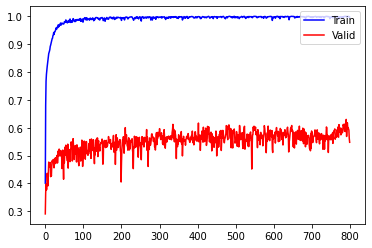

In [ ]:
import matplotlib.pyplot as plt

train_acc_record=np.array(torch.tensor(train_acc_record,device='cpu'))
valid_acc_record=np.array(torch.tensor(valid_acc_record,device='cpu'))

x = np.arange(len(train_acc_record))
plt.plot(x, train_acc_record, color="blue", label="Train")
plt.plot(x, valid_acc_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.show()

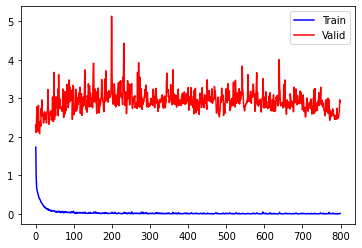

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(train_loss_record))
plt.plot(x, train_loss_record, color="blue", label="Train")
plt.plot(x, valid_loss_record, color="red", label="Valid")
plt.legend(loc="upper right") 
plt.show()

In [ ]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


In [ ]:
# Save Prediction Results
from datetime import datetime,timezone,timedelta
def save_pred(predictions, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    
    with open(file, 'w') as f:
      f.write('Id,Category\n')
      for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


dt1 = datetime.utcnow().replace(tzinfo=timezone.utc)
dt2 = dt1.astimezone(timezone(timedelta(hours=8))) # convert time zone
filename='hero_hw_03_'+dt2.strftime("%Y_%m_%d-%I_%M_%S_%p")+'.csv'
save_pred(predictions, filename)         # save prediction file to pred.csv

Saving results to hero_hw_03_2022_09_19-09_42_55_AM.csv


In [ ]:
# Note
# 01. do_image_augmentation
# 02. try resnet18 model
# 03. tune hyper_para
# 04. add plot loss_record acc_record
# 05. save best performance model
# 06. do semi-supervised learning

In [12]:
# Result

# hero_hw_03_2022_09_19-09_42_55_AM.csv  (resnet18, pretrained = False)
# Score: 0.59294
# Private score: 0.58960

# hero_hw_03_2022_09_18-01_44_36_AM.csv  (resnet18, pretrained = True)
# Score: 0.76881
# Private score: 0.79019

In [13]:
# Ref

# 01. sample code: https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW03/HW03.ipynb
# 02. data augmentation: https://datac.blog.csdn.net/article/details/107908762
# 03. ref code: https://github.com/lyfer233/deeplearning/blob/main/LiHongYi_ML2021Spring/HW3/%E7%82%BC%E4%B8%B9%E6%80%BB%E7%BB%93%E5%92%8C%E6%80%9D%E8%B7%AF.md
# 04. ref code: https://github.com/1am9trash/Hung_Yi_Lee_ML_2021/blob/main/hw/hw3/hw3_code.ipynb
# 05. resnet: https://zhuanlan.zhihu.com/p/225597229 
# 06. 